# Skincare Product  Recommender System

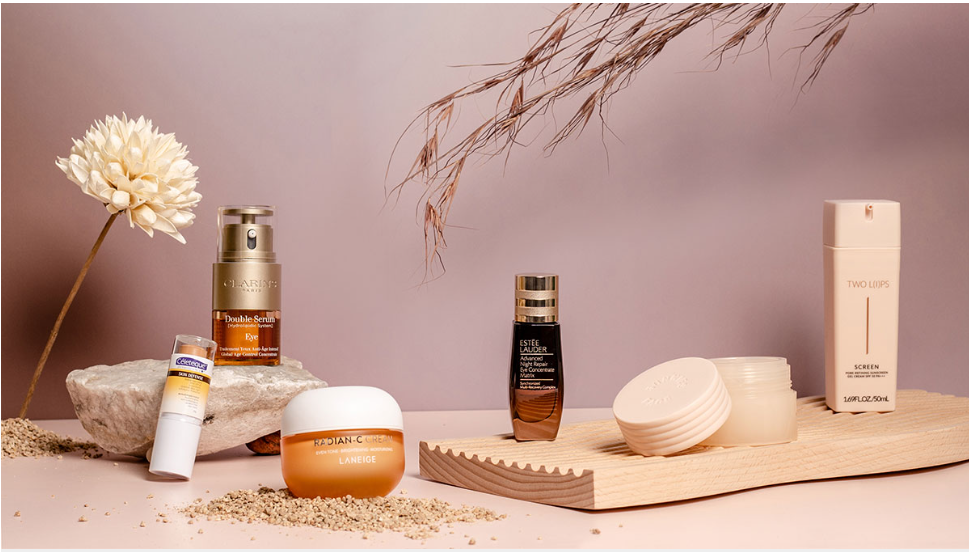

# Introduction
In the realm of machine learning-based recommender systems, the field of cosmetics and skin care products have often been overlooked. However, we firmly believe that by developing a comprehensive recommender system, we can greatly simplify the process of finding the perfect products tailored to each individual's personalized needs. Our goal is to create a one-stop shop experience where users receive recommendations for a complete skin care products based on their  personalized factors (such as skin type, skin tone), similar user choices, and budget. By leveraging these insights, we aim to provide users with a curated selection of products that will enable them to achieve their desired look effortlessly. Through this project, we aspire to revolutionize the way cosmetics are recommended and empower users to make informed choices.



# Problem Statement
One of the key challenges in e-commerce is effectively matching customers with products that align with their interests especially in the beauty and cosmetics industry. Many Users have relied on Influencers, advertisements and promotions to experiment on the best products to use for their skincare. There is a wealth of information hidden in  past purchase history and reviews that can provide valuable insights into their tastes and preferences. However, existing recommender systems often overlook this historical data, limiting their ability to provide accurate and personalized recommendations. The problem at hand is to leverage the on the data to build a data-driven recommender system that can accurately  predict products that are likely to be of interest to the users.

# Objectives
The primary objective of this project is to develop a robust skincare recommender system that offers a one-stop shop experience for users seeking beauty and cosmetics products.
* Developing an intuitive user interface that allows users to input their preferences, such as skin type, skin tone and budget preferences.
* Implementing collaborative filtering algorithms to analyze user data and generate personalized recommendations.
* Providing users with a curated selection of products from different categories  to create a cohesive and personalized skincare.


## Sucess Metrics
* A RMSE(Root Mean Squared Error) of less than 0.05
* A MAE(Mean Absolute Error) of less than 0.05
* Precision, recall and accuracy of higher than 90


# Data Understanding
The project utilizes a combination of scraped data that we from the Sephora website and the  [Kaggle](https://www.kaggle.com/datasets/nadyinky/sephora-products-and-skincare-reviews)  dataset that was scraped in March 2023. It contains:

* information about all beauty products (over 9,000) from the Sephora online store, including product and brand names, prices, ingredients, ratings, and all features.
* user reviews (over 1 million on over 2,000 products) of all products from the Skincare category, including user appearances, and review ratings by other users



In [1]:
#importing relevant libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.subplots as sp
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

import plotly.subplots as sp
import plotly.graph_objects as go
from scipy.stats import skew
from scipy.sparse import csr_matrix
from sklearn.metrics import average_precision_score
from surprise import accuracy

from surprise import SVDpp
from sklearn.metrics import mean_squared_error
from surprise import KNNBasic
from surprise import SVD
from surprise import Reader,Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from sklearn.pipeline import Pipeline
import glob
# import display that can display maximum columns and rows
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score


# Data loading


First, we will create a class that loads and describes our data.

In [2]:
class FileLoader:
    def __init__(self, filename=None):
        """
        Initialize the FileLoader object.

        Parameters:
        - filename (str): Optional. The filename of the file to load.
        """
        self.filename = filename
        self.data = None

    def load_csv(self):
        """
        Load a CSV file using the specified filename.
        """
        try:
            self.data = pd.read_csv(self.filename)
            print(f"CSV file '{self.filename}' loaded successfully!")
        except FileNotFoundError:
            print("File not found. Please provide a valid filename.")

    def load_json(self):
        """
        Load a JSON file using the specified filename.
        """
        try:
            self.data = pd.read_json(self.filename)
            print(f"JSON file loaded successfully!")
        except FileNotFoundError:
            print("File not found. Please provide a valid filename.")

    def describe(self):
        """
        Display information about the loaded data.
        """
        if self.data is not None:
            # Display the DataFrame shape
            shape = self.data.shape
            print('============================')
            print(f'DataFrame shape: {shape}\n')

            # Display the DataFrame info
            print('================================================================')
            info = self.data.info()
            print(f'DataFrame info: {info}\n')

            # Display the DataFrame description
            print('================================================================')
            description = self.data.describe()
            print(f'DataFrame description: {description}\n')

        else:
            print("No data loaded. Please load a file first using the 'load_csv' or 'load_json' methods.")

Loading products data

In [3]:
# Create an instance of FileLoader to load our products data
loader = FileLoader('product_info.csv')

# Load the CSV file
loader.load_csv()
info = loader.data

# Describe the loaded data
loader.describe()
# # Print the head of the DataFrame
info.head(3)

CSV file 'product_info.csv' loaded successfully!
DataFrame shape: (8494, 27)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 no

,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,variation_desc,ingredients,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,NaN,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",35.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0,0,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


### Loading additional products data that we scraped.

In [4]:
# Change the filename to 'scraped.json'
loader.filename = "data/data.json"

# Load the JSON file
loader.load_json()
scraped = loader.data

# Describe the loaded data
loader.describe()
# Print the head of the DataFrame
scraped.head(3)

JSON file loaded successfully!
DataFrame shape: (1371, 9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371 entries, 0 to 1370
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source       1371 non-null   object
 1   brand        1371 non-null   object
 2   title        1371 non-null   object
 3   description  1369 non-null   object
 4   categories   1371 non-null   object
 5   options      1371 non-null   object
 6   variants     1371 non-null   object
 7   medias       1371 non-null   object
 8   stats        1371 non-null   object
dtypes: object(9)
memory usage: 96.5+ KB
DataFrame info: None

DataFrame description:                                                    source               brand  \
count                                                1371                1371   
unique                                               1371                 167   
top     {'id': 'P505386', 'crawlUrl': 'https://www.sep.

,source,brand,title,description,categories,options,variants,medias,stats
0,"{'id': 'P427419', 'crawlUrl': 'https://www.sep...",The Ordinary,Hyaluronic Acid 2% + B5 Hydrating Serum,<p><strong>Which skin type is it good for?</st...,"[Skincare, Treatments, Face Serums]","[{'type': 'Size', 'values': [{'id': '1 oz/ 30 ...","[{'id': '2031375', 'sku': '2031375', 'price': ...","[{'type': 'Image', 'url': 'https://www.sephora...","{'reviewCount': 4228, 'rating': 4.2114, 'loves..."
1,"{'id': 'P427417', 'crawlUrl': 'https://www.sep...",The Ordinary,Niacinamide 10% + Zinc 1% Oil Control Serum,<b>What it is: </b>A high-strength vitamin-an...,"[Skincare, Treatments, Face Serums]","[{'type': 'Size', 'values': [{'id': '1 oz/ 30 ...","[{'id': '2031391', 'sku': '2031391', 'price': ...","[{'type': 'Image', 'url': 'https://www.sephora...","{'reviewCount': 6185, 'rating': 4.2325, 'loves..."
2,"{'id': 'P458219', 'crawlUrl': 'https://www.sep...",Glow Recipe,Watermelon Glow PHA + BHA Pore-Tight Toner,"<p><strong>What it is: </strong>A bestselling,...","[Skincare, Cleansers, Toners]","[{'type': 'Size', 'values': [{'id': '1.35 oz/ ...","[{'id': '2421519', 'sku': '2421519', 'price': ...","[{'type': 'Image', 'url': 'https://www.sephora...","{'reviewCount': 3858, 'rating': 4.3362, 'loves..."


In [5]:
#create a copy of the scraped data
scraped_copy = scraped.copy()

* We were able to add 1371 more products from our our original data with 8494 products.
* To improve the formatting of the scraped data, which was in JSON format, we need to iterate through the JSON objects in each column and extract individual product features. Once this step is complete, we can merge the cleaned data with the product data from Kaggle. Additionally, we will develop classes to facilitate the cleaning process for the JSON data.

## Cleaning scraped data

In [6]:
class ProductScraper:
    def __init__(self, data):
        self.data = data
        self.product_ids = []

    def extract_product_ids(self):
        for row in self.data['source']:
            product_id = row['id']
            self.product_ids.append(product_id)

    def add_product_ids_column(self):
        self.data['product_id'] = self.product_ids


def scrape_product_ids():
    scraper = ProductScraper(scraped_copy)
    scraper.extract_product_ids()
    scraper.add_product_ids_column()


if __name__ == '__main__':
    scrape_product_ids()


In [7]:
class CategoryExtractor:
    def __init__(self, data):
        self.data = data
        self.primary_categories = []
        self.secondary_categories = []
        self.tertiary_categories = []

    def extract_categories(self):
        for row in self.data['categories']:
            primary_category = row[0]
            secondary_category = row[1] if len(row) > 1 else None
            tertiary_category = row[-1] if len(row) > 2 else None

            self.primary_categories.append(primary_category)
            self.secondary_categories.append(secondary_category)
            self.tertiary_categories.append(tertiary_category)

    def add_category_columns(self):
        self.data['primary_category'] = self.primary_categories
        self.data['secondary_category'] = self.secondary_categories
        self.data['tertiary_category'] = self.tertiary_categories


def extract_and_add_categories():
    category_extractor = CategoryExtractor(scraped_copy)
    category_extractor.extract_categories()
    category_extractor.add_category_columns()


if __name__ == '__main__':
    extract_and_add_categories()


In [8]:
class StatsExtractor:
    def __init__(self, data):
        self.data = data
        self.ratings = []
        self.loves_counts = []
        self.reviews = []

    def extract_stats(self):
        for row in self.data['stats']:
            rating = row['rating']
            loves_count = row['lovesCount']
            review_count = row['reviewCount']

            self.ratings.append(rating)
            self.loves_counts.append(loves_count)
            self.reviews.append(review_count)

    def add_stats_columns(self):
        self.data['rating'] = self.ratings
        self.data['loves_count'] = self.loves_counts
        self.data['reviews'] = self.reviews


def extract_and_add_stats():
    stats_extractor = StatsExtractor(scraped_copy)
    stats_extractor.extract_stats()
    stats_extractor.add_stats_columns()


if __name__ == '__main__':
    extract_and_add_stats()


In [9]:
class PriceExtractor:
    def __init__(self, data):
        self.data = data
        self.prices = []

    def extract_prices(self):
        for row in self.data['variants']:
            price = None
            for variant in row:
                if 'price' in variant and 'current' in variant['price']:
                    price = variant['price']['current']
                    break
            self.prices.append(price)

    def add_price_column(self):
        self.data['price_usd'] = self.prices



def extract_and_add_prices():
    price_extractor = PriceExtractor(scraped_copy)
    price_extractor.extract_prices()
    price_extractor.add_price_column()


if __name__ == '__main__':
    extract_and_add_prices()


In [10]:
class SizeExtractor:
    def __init__(self, data):
        self.data = data
        self.sizes = []

    def extract_sizes(self):
        for row in self.data['variants']:
            size = None
            for variant in row:
                if 'options' in variant:
                    options = variant['options']
                    if isinstance(options, list) and len(options) > 0:
                        size = options[0]
                        break
            self.sizes.append(size)

    def add_size_column(self):
        self.data['size'] = self.sizes


def extract_and_add_sizes():
    size_extractor = SizeExtractor(scraped_copy)
    size_extractor.extract_sizes()
    size_extractor.add_size_column()


if __name__ == '__main__':
    extract_and_add_sizes()


scraped_copy.head(3)


,source,brand,title,description,categories,options,variants,medias,stats,product_id,primary_category,secondary_category,tertiary_category,rating,loves_count,reviews,price_usd,size
0,"{'id': 'P427419', 'crawlUrl': 'https://www.sep...",The Ordinary,Hyaluronic Acid 2% + B5 Hydrating Serum,<p><strong>Which skin type is it good for?</st...,"[Skincare, Treatments, Face Serums]","[{'type': 'Size', 'values': [{'id': '1 oz/ 30 ...","[{'id': '2031375', 'sku': '2031375', 'price': ...","[{'type': 'Image', 'url': 'https://www.sephora...","{'reviewCount': 4228, 'rating': 4.2114, 'loves...",P427419,Skincare,Treatments,Face Serums,4.2114,829334,4228,890,1 oz/ 30 mL
1,"{'id': 'P427417', 'crawlUrl': 'https://www.sep...",The Ordinary,Niacinamide 10% + Zinc 1% Oil Control Serum,<b>What it is: </b>A high-strength vitamin-an...,"[Skincare, Treatments, Face Serums]","[{'type': 'Size', 'values': [{'id': '1 oz/ 30 ...","[{'id': '2031391', 'sku': '2031391', 'price': ...","[{'type': 'Image', 'url': 'https://www.sephora...","{'reviewCount': 6185, 'rating': 4.2325, 'loves...",P427417,Skincare,Treatments,Face Serums,4.2325,842841,6185,600,1 oz/ 30 mL
2,"{'id': 'P458219', 'crawlUrl': 'https://www.sep...",Glow Recipe,Watermelon Glow PHA + BHA Pore-Tight Toner,"<p><strong>What it is: </strong>A bestselling,...","[Skincare, Cleansers, Toners]","[{'type': 'Size', 'values': [{'id': '1.35 oz/ ...","[{'id': '2421519', 'sku': '2421519', 'price': ...","[{'type': 'Image', 'url': 'https://www.sephora...","{'reviewCount': 3858, 'rating': 4.3362, 'loves...",P458219,Skincare,Cleansers,Toners,4.3362,359228,3858,1500,1.35 oz/ 40 mL


Now that we have extracted all the necessary features for our analysis from the data, we can proceed to merge all the products and reviews data into one dataframe. This merged dataframe will contain consolidated information from both sources, enabling us to analyze the data more effectively.

### Reading all the reviews data

In [11]:
# Use glob to find CSV filenames starting with "reviews"
csv_filenames = glob.glob("data/reviews*.csv")

# Create a dictionary to store the data with custom variable names
datasets = {}

# Load each CSV file and assign it to a variable name
for i, filename in enumerate(csv_filenames, 1):
    variable_name = f"review_{i}"
    loader.filename = filename
    loader.load_csv()
    datasets[variable_name] = loader.data

CSV file 'data\reviews_0_250.csv' loaded successfully!
CSV file 'data\reviews_1000_1500.csv' loaded successfully!
CSV file 'data\reviews_1500_end.csv' loaded successfully!
CSV file 'data\reviews_250_500.csv' loaded successfully!
CSV file 'data\reviews_500_750.csv' loaded successfully!
CSV file 'data\reviews_750_1000.csv' loaded successfully!


In [12]:
# Concatenate all the review DataFrames
merged_reviews = pd.concat([datasets['review_1'], datasets['review_2'], datasets['review_3'], datasets['review_4'], datasets['review_5'], datasets['review_6']])

# Reset the index of the merged DataFrame
merged_reviews = merged_reviews.reset_index(drop=True)

# Print the merged DataFrame
print(merged_reviews.shape)
merged_reviews.head(3)

(1301136, 19)


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0




We have 1,301,136 rows and 19 columns in our review dataframe.

Let's now merge the product information data, the scraped product information data, and the reviews data into one final dataset.

## Final data

In [13]:
# Concatenate all the products DataFrames
products_df = pd.concat([info, scraped])

# Reset the index of the merged DataFrame
products_df = products_df.reset_index(drop=True)

# Print the merged DataFrame
print(products_df.shape)
products_df.head(3)

(9865, 36)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,variation_desc,ingredients,price_usd,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price,source,brand,title,description,categories,options,variants,medias,stats
0,P473671,Fragrance Discovery Set,6342.0,19-69,6320.0,3.6364,11.0,NaN,NaN,NaN,NaN,"['Capri Eau de Parfum:', 'Alcohol Denat. (SD A...",35.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342.0,19-69,3827.0,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2.0,85.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P473662,Rainbow Bar Eau de Parfum,6342.0,19-69,3253.0,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,NaN,"['Alcohol Denat. (SD Alcohol 39C), Parfum (Fra...",195.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2.0,75.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
"""Function to merge all products and users information data"""
def merge_dataframe(data_0, data_1, merge_column):
    """A function to merge the datasets based on a given column"""
    new_df = data_0.merge(data_1, on=merge_column)
    return new_df

df = merge_dataframe(products_df, merged_reviews, "product_id")
print(df.shape)
df.head(3)

(1301136, 54)


,product_id,product_name_x,brand_id,brand_name_x,loves_count,rating_x,reviews,size,variation_type,variation_value,variation_desc,ingredients,price_usd_x,value_price_usd,sale_price_usd,limited_edition,new,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price,source,brand,title,description,categories,options,variants,medias,stats,Unnamed: 0,author_id,rating_y,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_name_y,brand_name_y,price_usd_y
0,P439055,GENIUS Sleeping Collagen Moisturizer,6018.0,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,Size,2 oz/ 60 mL,NaN,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,556982,5880814443,5,1.0,1.000000,2,0,2,2023-02-09,"Ever since I bought this, I noticed that my sk...",Must have,medium,brown,oily,black,GENIUS Sleeping Collagen Moisturizer,Algenist,98.0
1,P439055,GENIUS Sleeping Collagen Moisturizer,6018.0,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,Size,2 oz/ 60 mL,NaN,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,556983,1726924575,5,1.0,0.333333,3,2,1,2023-01-13,This cream feels so silky and luxurious! I fee...,Luxurious treat I use nightly.,NaN,NaN,NaN,NaN,GENIUS Sleeping Collagen Moisturizer,Algenist,98.0
2,P439055,GENIUS Sleeping Collagen Moisturizer,6018.0,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,Size,2 oz/ 60 mL,NaN,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,NaN,NaN,0.0,0.0,0.0,0.0,1.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,556984,1551348158,5,1.0,1.000000,5,0,5,2022-12-09,This is the fourth Algenist product I’ve gotte...,Algenist doesn't miss,NaN,NaN,combination,NaN,GENIUS Sleeping Collagen Moisturizer,Algenist,98.0


In [15]:
#creating a copy of the dataframe
data =df.copy()

* Our final dataframe consist of  1,301,136 rows and 54 columns.
* Some of the columns are duplicates because of the merging
* Some columns exhibit missing values, as indicated by a non-null count less than the total number of rows (1,301,136).



# Data Cleaning

The steps involved here will be:

* Detecting and dealing with duplicates.
* Handling missing values.
* Dealing with outliers.

## Subsetting


To prepare the dataframe for analysis and modeling, we will subset it by dropping duplicated columns, removing columns in JSON format, and retaining only the necessary columns for our analysis.

In [16]:
#subsetting to obtain relevant columns
new_data = data[['author_id', 'product_id', 'product_name_x', 'brand_name_x',
       'loves_count', 'rating_x', 'reviews', 'size',
       'ingredients', 'price_usd_x', 'highlights',
       'primary_category', 'secondary_category', 'tertiary_category',
       'is_recommended', 'helpfulness', 'review_text',
        'skin_tone', 'eye_color', 'skin_type', 'hair_color',
        ]]
print(new_data.shape)
new_data.head()

(1301136, 21)


,author_id,product_id,product_name_x,brand_name_x,loves_count,rating_x,reviews,size,ingredients,price_usd_x,highlights,primary_category,secondary_category,tertiary_category,is_recommended,helpfulness,review_text,skin_tone,eye_color,skin_type,hair_color
0,5880814443,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,1.0,1.000000,"Ever since I bought this, I noticed that my sk...",medium,brown,oily,black
1,1726924575,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,1.0,0.333333,This cream feels so silky and luxurious! I fee...,NaN,NaN,NaN,NaN
2,1551348158,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,1.0,1.000000,This is the fourth Algenist product I’ve gotte...,NaN,NaN,combination,NaN
3,8222942765,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,1.0,0.800000,I’ve been using this for 2 months now and I ca...,light,brown,combination,blonde
4,2403670662,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,0.0,0.111111,I don’t like the smell. It pills on your skin ...,fair,green,combination,blonde


After subsetting the dataframe, we are left with 21 columns and 1,301,136 rows. Now, we can proceed with the data cleaning process to ensure the data is consistent and ready for analysis.

## Duplicates

In [17]:
 """Function that iterates through the rows of our dataset to check whether  they are duplicated or not"""
duplicates = []
def check_duplicates(data):
   
    for i in data.duplicated():
        duplicates.append(i)
    duplicates_set = set(duplicates)
    if(len(duplicates_set) == 1):
        print('The Dataset has No Duplicates')
    else:
        duplicates_percentage = np.round(((sum(duplicates)/len(data)) * 100 ), 2)
        print(f'Duplicated rows constitute of {duplicates_percentage} % of our dataset')




In [18]:
check_duplicates(new_data)

Duplicated rows constitute of 15.91 % of our dataset


# Missing Values

In [19]:
"""Checking missing values"""
def missing_values(data):
    #identify missing values per columns
    miss = data.isna().sum()
    #calculate percentage of missing values per columns
    percentage = (data.isna().sum()/len(data)).round(4)
    #create a dataframe
    return pd.DataFrame({'Missing values':miss, 'Percentage':percentage})
missing_values(new_data)

,Missing values,Percentage
author_id,0,0.0000
product_id,0,0.0000
product_name_x,0,0.0000
brand_name_x,0,0.0000
loves_count,0,0.0000
rating_x,0,0.0000
reviews,0,0.0000
size,49459,0.0380
ingredients,25177,0.0194
price_usd_x,0,0.0000



* 10 columns have no missing values, while another 4 have less than 10 percent of their data missing.
* The "Helpfulness" column, which is the ratio of the number of positive feedback divided by the total positive feedback, has approximately 51 percent of its data missing. We assume this is because it either represents negative feedback or no feedback at all, so we will fill the missing values with zero.
* User feature columns such as user skintone, skintype, eyecolor, and haircolor have approximately 20 percent of their data missing. Since these columns are very sensitive (as guessing users' features is not possible) and crucial for our modeling, we will have to drop the missing values.

# Outliers

In [20]:
# dividing into numerical and categorical columns
numerical_columns = new_data[['loves_count', 'rating_x','reviews', 'price_usd_x', 'is_recommended',
                              'helpfulness']]
categorical_columns =new_data.select_dtypes(exclude = "number")

In [21]:
"""Function to check for outliers"""
def check_outliers(data, columns):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))
    axes = axes.flatten()  # Convert axes array to 1D

    for i, column in enumerate(columns):
        # Use interquartile range (IQR) to find outliers for the specified column
        q1 = data[column].quantile(0.25)
        q3 = data[column].quantile(0.75)
        iqr = q3 - q1
       
        # Determine the outliers based on the IQR
        outliers = (data[column] < q1 - 1.5 * iqr) | (data[column] > q3 + 1.5 * iqr)
       # print("Number of outliers in {} column: {}".format(column, outliers.sum()))

        # Create a box plot to visualize the distribution of the specified column
        sns.boxplot(data=data, x=column, ax=axes[i])
    plt.tight_layout()
    plt.show()

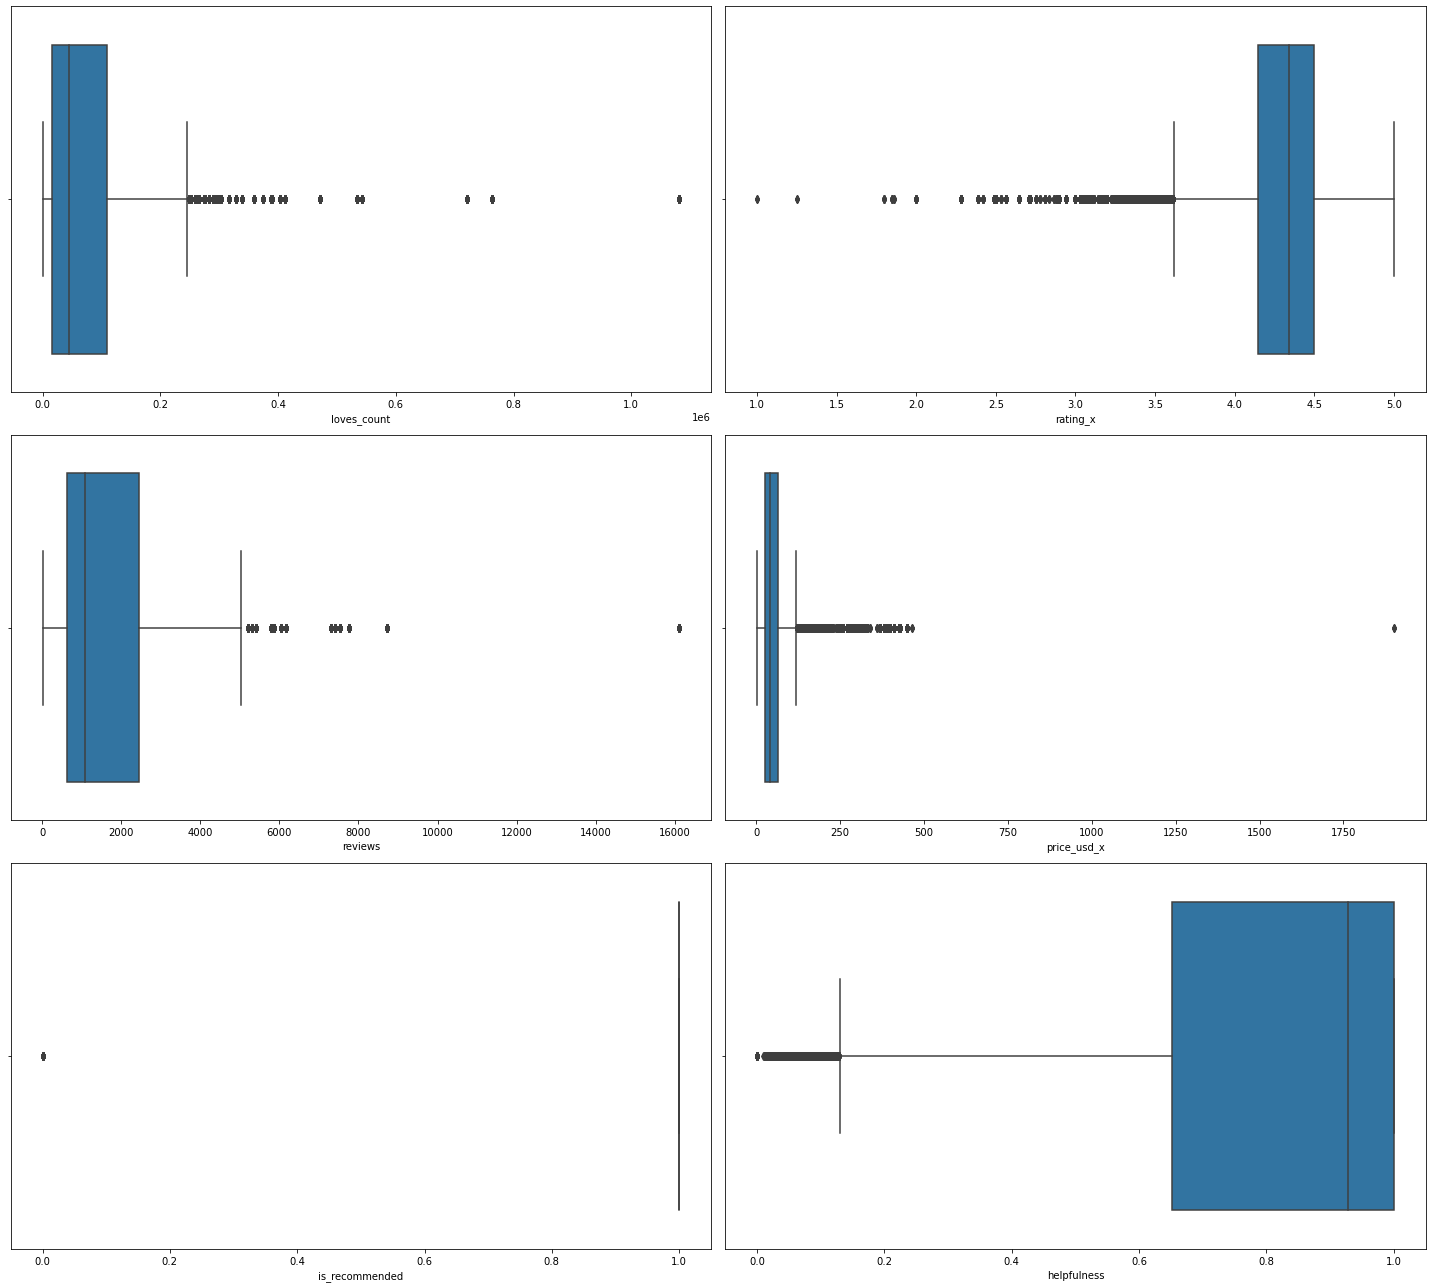

In [22]:
check_outliers(new_data, numerical_columns)

* Data points that appear as outliers in the `love_counts` and `reviews` columns are likely due to certain products that were highly liked and reviewed by users. During exploratory data analysis (EDA), we will visualize these data points to identify which products they correspond to.

* The `is_recommended` column is binary, with values of either 0 or 1. Since the mean is 1, the presence of data points with a value of 0 does not indicate an outlier in the true sense.

* The `Price` column contains an outlier, indicating the presence of an expensive product.  Additionally, the `helpfulness` column shows some values of 0, but the majority of the products have values above 0.8, indicating that they are highly helpful to users.

# Dealing With Duplicates

In [23]:
#dropping duplicates
new_data.drop_duplicates(inplace =True)
new_data.duplicated().sum()

0

# Dealing With Missing Values

In [24]:
#filling helpfullness column with 0
new_data['helpfulness'].fillna(0, inplace =True)
#dropping remaining missing values
new_data.dropna(inplace=True)
new_data.isna().sum()

author_id             0
product_id            0
product_name_x        0
brand_name_x          0
loves_count           0
rating_x              0
reviews               0
size                  0
ingredients           0
price_usd_x           0
highlights            0
primary_category      0
secondary_category    0
tertiary_category     0
is_recommended        0
helpfulness           0
review_text           0
skin_tone             0
eye_color             0
skin_type             0
hair_color            0
dtype: int64

In [25]:
#preview of our cleaned data
print(new_data.shape)

#preview of the rows and columns
new_data.head(3)

(630808, 21)


,author_id,product_id,product_name_x,brand_name_x,loves_count,rating_x,reviews,size,ingredients,price_usd_x,highlights,primary_category,secondary_category,tertiary_category,is_recommended,helpfulness,review_text,skin_tone,eye_color,skin_type,hair_color
0,5880814443,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,1.0,1.000000,"Ever since I bought this, I noticed that my sk...",medium,brown,oily,black
3,8222942765,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,1.0,0.800000,I’ve been using this for 2 months now and I ca...,light,brown,combination,blonde
4,2403670662,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,1321.0,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,0.0,0.111111,I don’t like the smell. It pills on your skin ...,fair,green,combination,blonde


* Our cleaned data has 630808 rows and 21 columns.

# Exploratory Data Analysis

In [26]:
#viewing numerical columns
numerical_columns

,loves_count,rating_x,reviews,price_usd_x,is_recommended,helpfulness
0,33910.0,4.5413,1321.0,98.0,1.0,1.000000
1,33910.0,4.5413,1321.0,98.0,1.0,0.333333
2,33910.0,4.5413,1321.0,98.0,1.0,1.000000
3,33910.0,4.5413,1321.0,98.0,1.0,0.800000
4,33910.0,4.5413,1321.0,98.0,0.0,0.111111
...,...,...,...,...,...,...
1301131,13592.0,4.2500,4.0,20.0,1.0,1.000000
1301132,13592.0,4.2500,4.0,20.0,1.0,0.888889
1301133,8189.0,3.0000,3.0,28.0,0.0,NaN
1301134,8189.0,3.0000,3.0,28.0,0.0,NaN


In [27]:
#viewing categorical columns
print(categorical_columns.columns)
#subsetting for visualization, we dont want to visualize columns like author_id and product_id
cat_cols =categorical_columns[['primary_category', 'secondary_category',
       'tertiary_category', 'skin_tone', 'eye_color', 'skin_type',
       'hair_color']]
cat_cols.columns

Index(['author_id', 'product_id', 'product_name_x', 'brand_name_x', 'size',
       'ingredients', 'highlights', 'primary_category', 'secondary_category',
       'tertiary_category', 'review_text', 'skin_tone', 'eye_color',
       'skin_type', 'hair_color'],
      dtype='object')


Index(['primary_category', 'secondary_category', 'tertiary_category',
       'skin_tone', 'eye_color', 'skin_type', 'hair_color'],
      dtype='object')

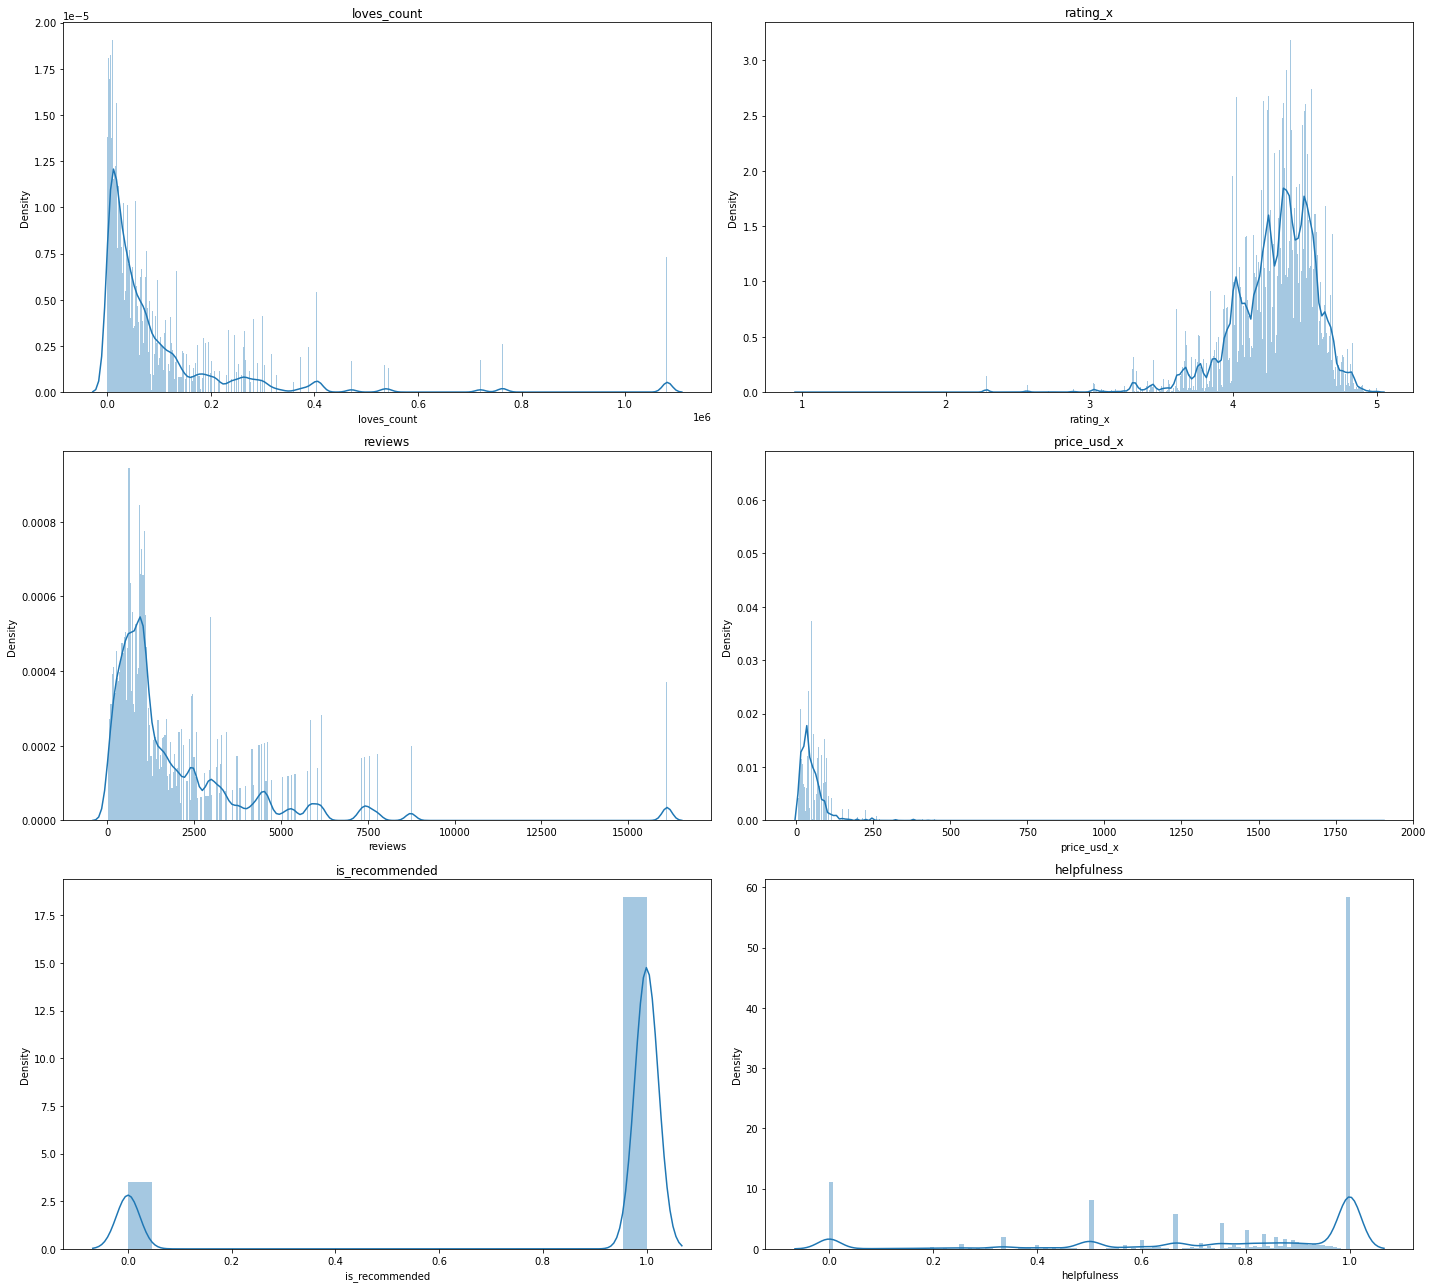

In [28]:
"""Visualizing numerical  columns"""
#create a figure and set subplots
fig, axes = plt.subplots(3,2, figsize = (20,18))
#iterate all the axes
ax = axes.flatten()

for i, col in enumerate(numerical_columns.columns):
    #plot an histogram for each column
    sns.distplot(numerical_columns[col], ax = ax[i], bins = 'auto')
    ax[i].set_title(col)
    
    
#adjust  padding
fig.tight_layout()
#display the plot
plt.show()




* Most of the numerical columns are not normally distributed; they seem skewed to one end.
* `loves_count` and `reviews` seem positively skewed, while `price` (in USD) is negatively skewed.
* Most of the products were recommended by users; hence, many of the values in the `is_recommended` column are 1.

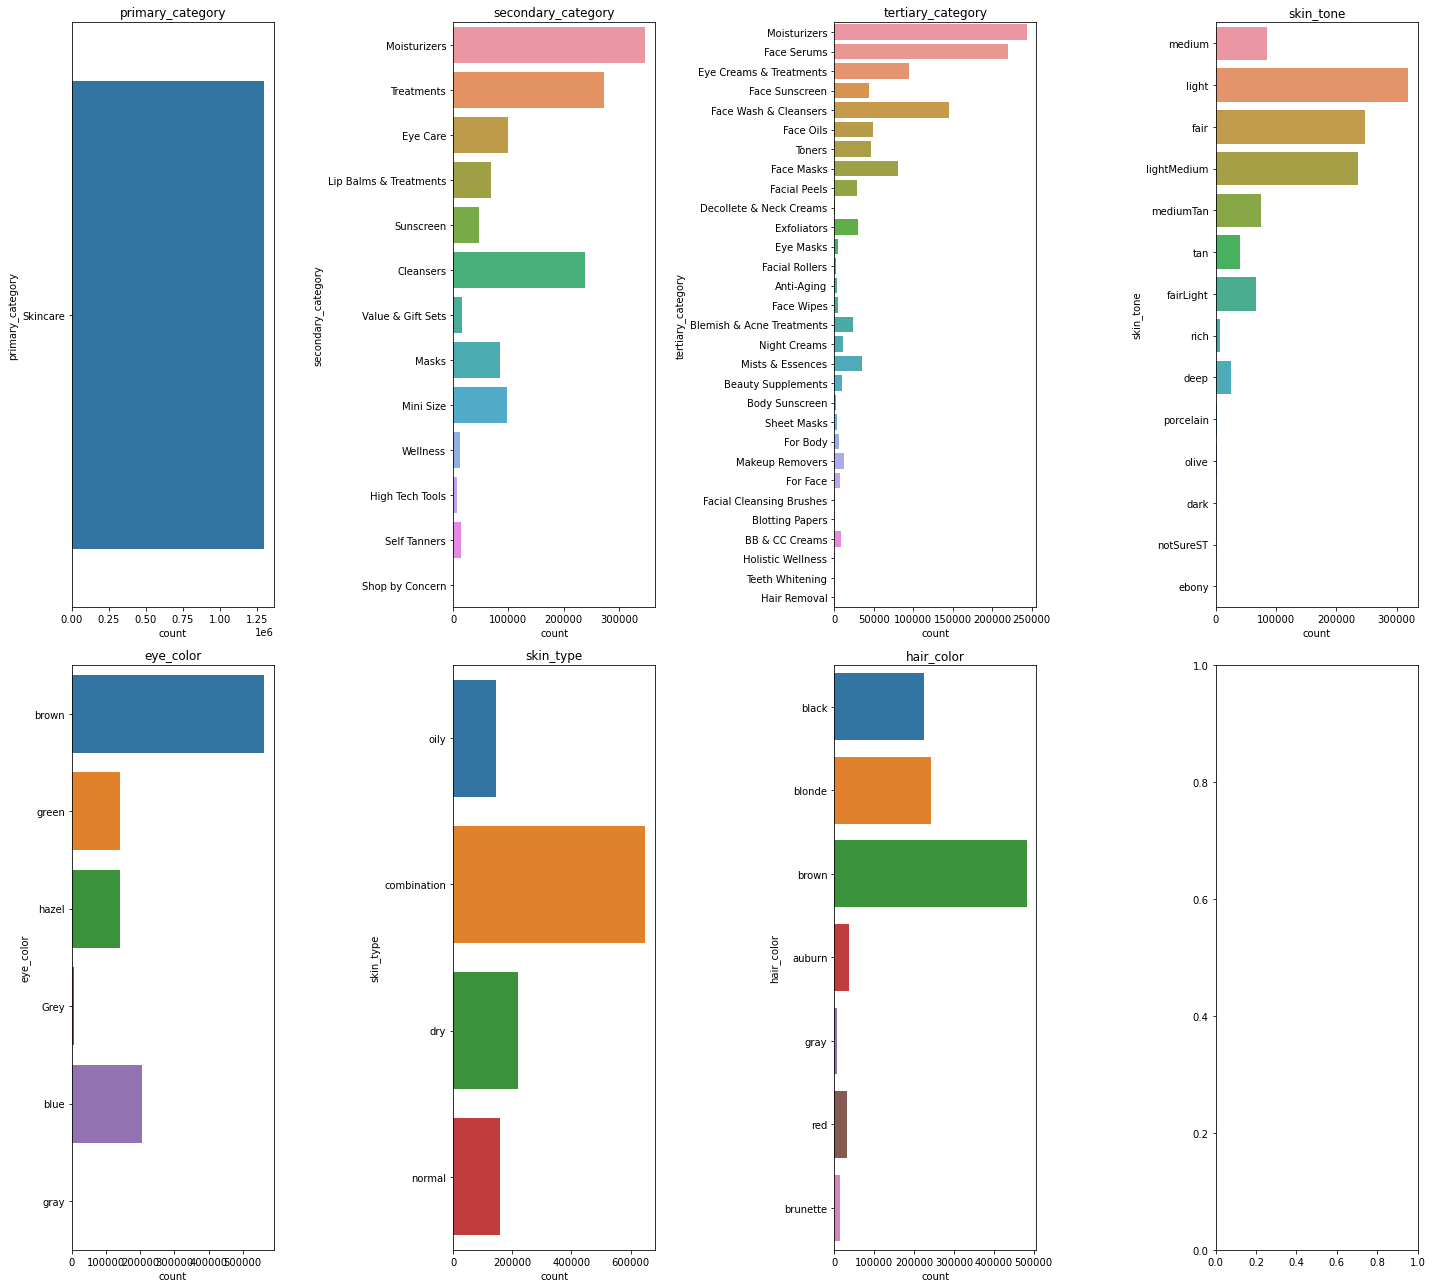

In [29]:
#visualizing categorical columns
fig, axes = plt.subplots(2, 4, figsize=(20, 18))
# Iterate over all the axes
ax = axes.flatten()

for i, col in enumerate(cat_cols.columns):
    # Plot a horizontal histogram for each column
    sns.countplot(y=cat_cols[col], ax=ax[i])
    ax[i].set_title(col)
  

# Adjust padding
fig.tight_layout()
# Display the plot
plt.show()

- The majority of the products we have are `moisturizers` followed by  `Face serums`.
- The majority of users have the following features:
  - Skin tone: light
  - Eye color: brown
  - Skin type: combination
  - Hair color: brown

### What are the top 10 most recommended products

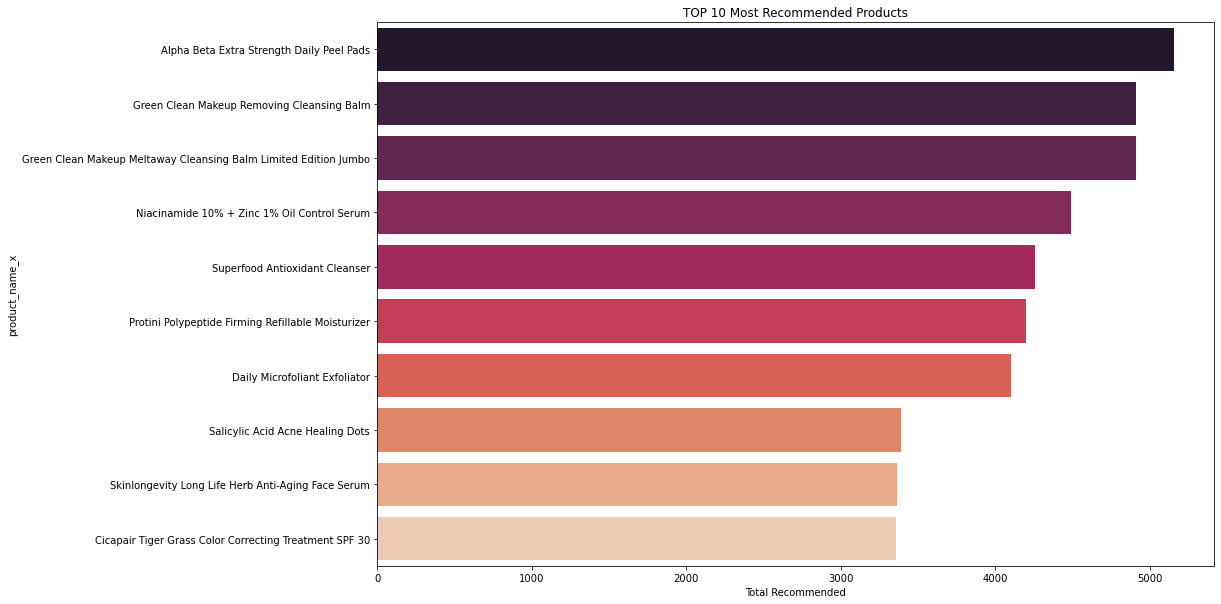

In [62]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

most_recommended = new_data.groupby(['product_id', 'product_name_x', 'brand_name_x']).sum(numeric_only=True)['is_recommended'].reset_index() \
    .sort_values('is_recommended', ascending=False).head(10)
sns.barplot(data=most_recommended, x='is_recommended', y='product_name_x', ax=ax1, palette = "rocket")
ax1.set_title("TOP 10 Most Recommended Products")
ax1.set_xlabel("Total Recommended")

plt.show()


* Alpha Beta Extra Strength Daily Peel Pads is the most recommended product, it is  a  two-step treatment that uses a combination of five potent Alpha and Beta Hydroxy Acids to help even the skin tone and texture, reduce the appearance of wrinkles and minimise enlarged pores.

### What are the top 10 most helpful products

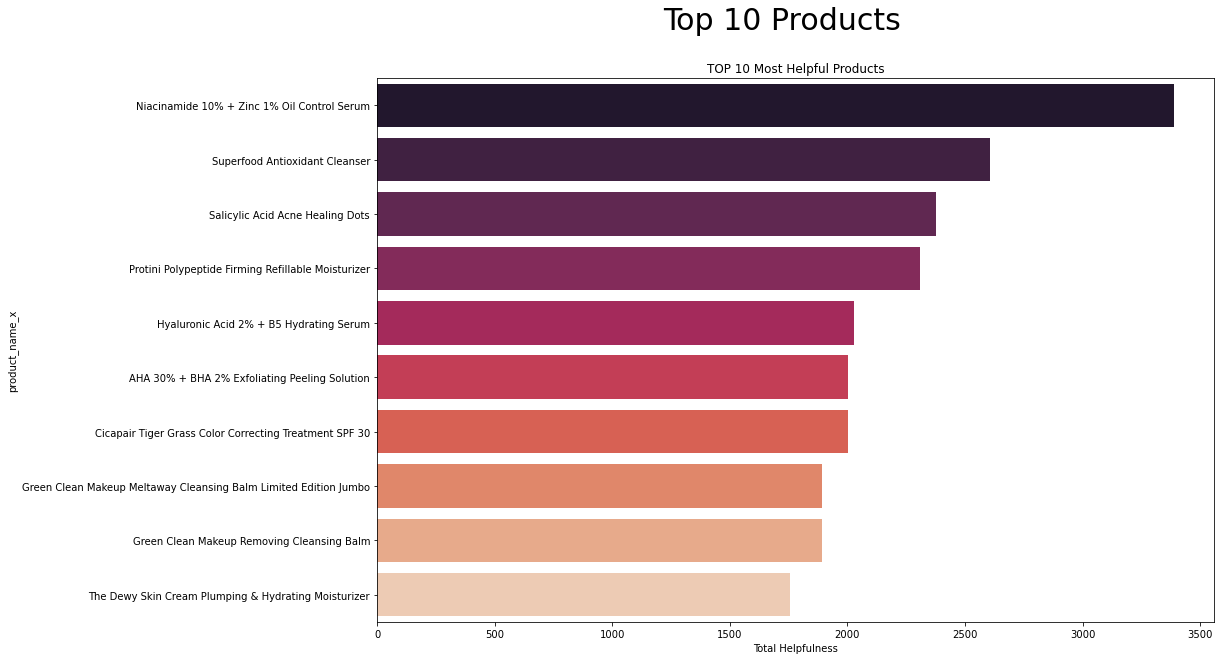

In [31]:
fig, (ax2) = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)
most_helpfulness = new_data.groupby(['product_id', 'product_name_x', 'brand_name_x']).sum(numeric_only=True)['helpfulness'].reset_index() \
    .sort_values('helpfulness', ascending=False).head(10)
sns.barplot(data=most_helpfulness, x='helpfulness', y='product_name_x', ax=ax2, palette = "rocket")
ax2.set_title("TOP 10 Most Helpful Products")
ax2.set_xlabel("Total Helpfulness")

plt.suptitle("Top 10 Products", fontsize=30)

plt.show()

Niacinamine 10% + Zinc 1%  Control Serum is the most helpful product, it is a water-based serum that boosts skin brightness, improves skin smoothness and reinforces the skin barrier over time.

### Most recommended for products for each skin type

In [32]:

def plot_top_products_by_skin_type(df, skin_types):
    fig, axes = plt.subplots(nrows=len(skin_types), ncols=1, figsize=(15, 5*len(skin_types)))
    fig.subplots_adjust(hspace=0.5)

    for i, skin_type in enumerate(skin_types):
        ax = axes[i]
        skin_type_data = new_data[new_data['skin_type'] == skin_type].sort_values(['rating_x', 'price_usd_x'], ascending=[False, True]).head(10)
        ax = sns.barplot(data=skin_type_data, x='price_usd_x', y='product_name_x', ax=ax, palette=  'mako_r')
        ax.set_title(f"Top products based on rating and price for {skin_type} skin type")
        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                            textcoords='offset points', ha='center', va='bottom')

    fig.suptitle("Most recommended product for each skin type", fontsize=30)
    plt.show()


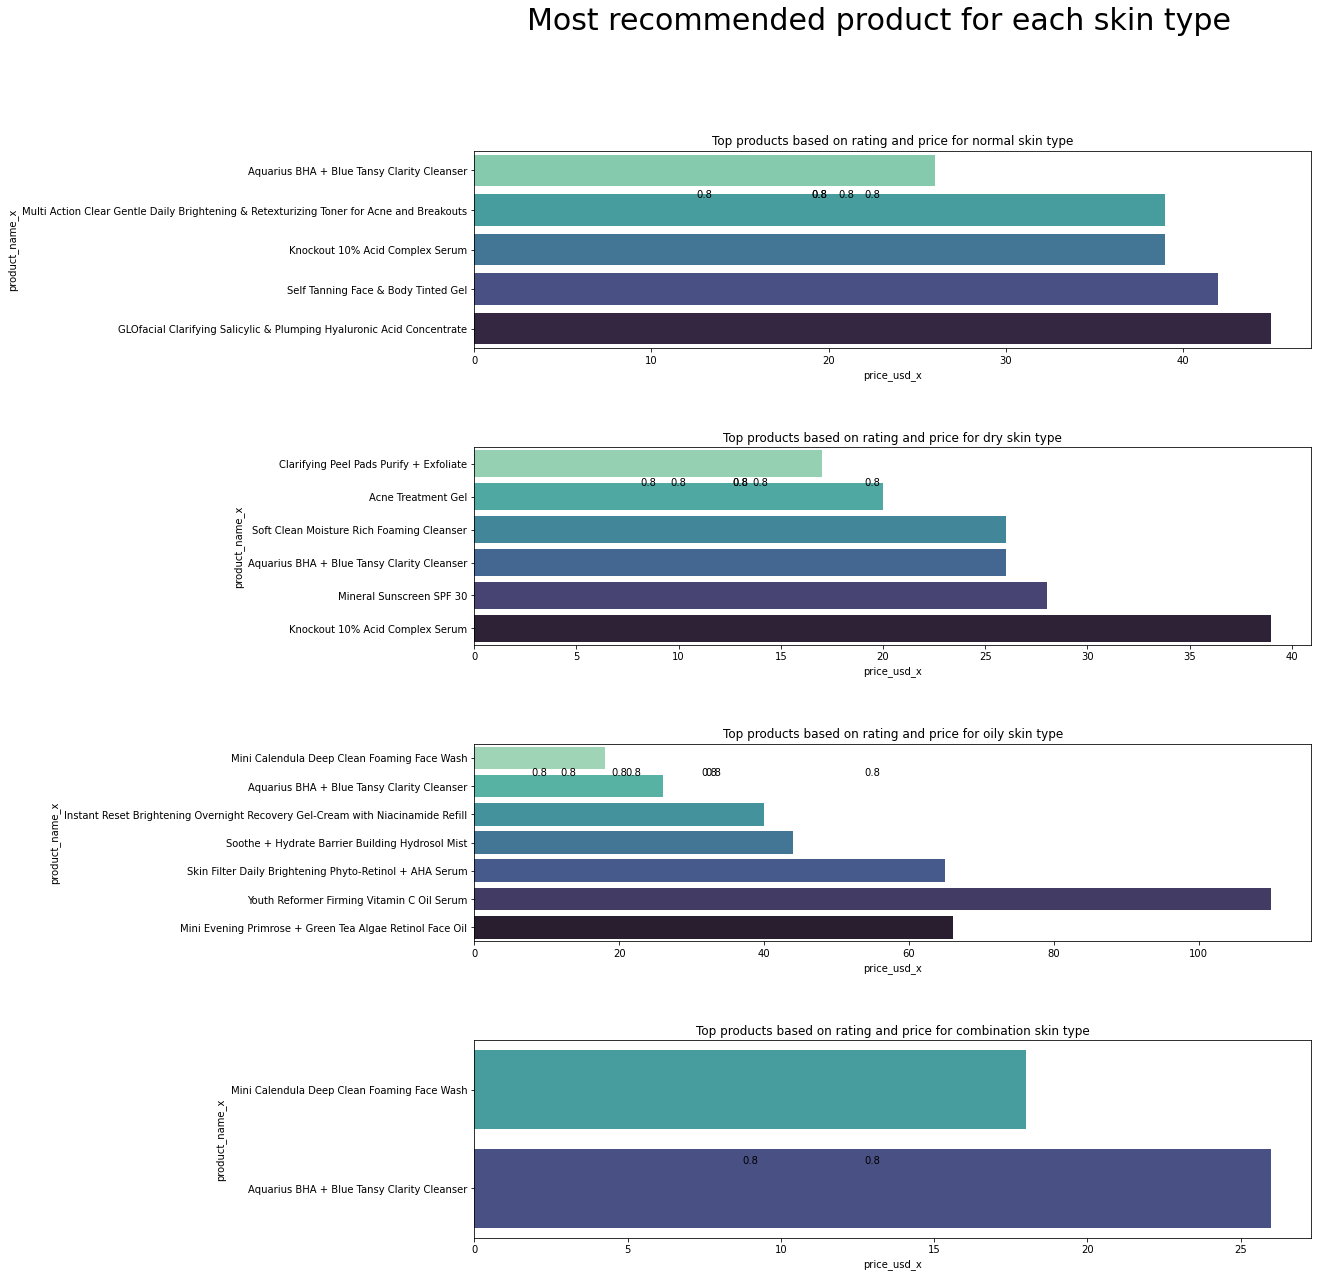

In [33]:
skin_types = ['normal', 'dry', 'oily', 'combination']
plot_top_products_by_skin_type(new_data, skin_types)

* For a normal skin,most users prefer `GLOfacial Clarifying Saliclic & Plumbing Hyluronic Acid Concentrate` which is a clarifying & plumping concentrate formulated to resurface and hydrate while minimizing the appearance of congested pores for calm, glowing skin.

* For a dry skin, the most preferred product is a `Knockout 10% Acid Complex Serum` which is mainly used for  more youthful-looking skin

* Users with oily skin mostly prefer the `Youth Reformer Firming Vitamin C Oil Serum` which redensifies the skin, reduces fine lines and wrinkles, and calms redness.

* For a combination skin, `Aquaris BHA + Blue Tansy Clarity Cleanser` A BHA gel cleanser that deep cleanses your pores and gently exfoliates oily-combination skin prone to breakouts is mostly preferred by users.

## Most recommended product for each skin tone

In [34]:

def plot_top_products_by_skin_tone(df, skin_tone):
    fig, axes = plt.subplots(nrows=len(skin_tone), ncols=1, figsize=(15, 5*len(skin_tone)))
    fig.subplots_adjust(hspace=0.5)

    for i, skin_tone in enumerate(skin_tone):
        ax = axes[i]
        skin_tone_data = df[df['skin_tone'] == skin_tone].sort_values(['rating_x', 'price_usd_x'], ascending=[False, True]).head(10)
        ax = sns.barplot(data=skin_tone_data, x='price_usd_x', y='product_name_x', ax=ax, palette='mako_r')
        ax.set_title(f"Top products based on rating and price for {skin_tone} skin tone")
        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                            textcoords='offset points', ha='center', va='bottom')

    fig.suptitle("Most recommended product for each skin tone", fontsize=30)
    plt.show()


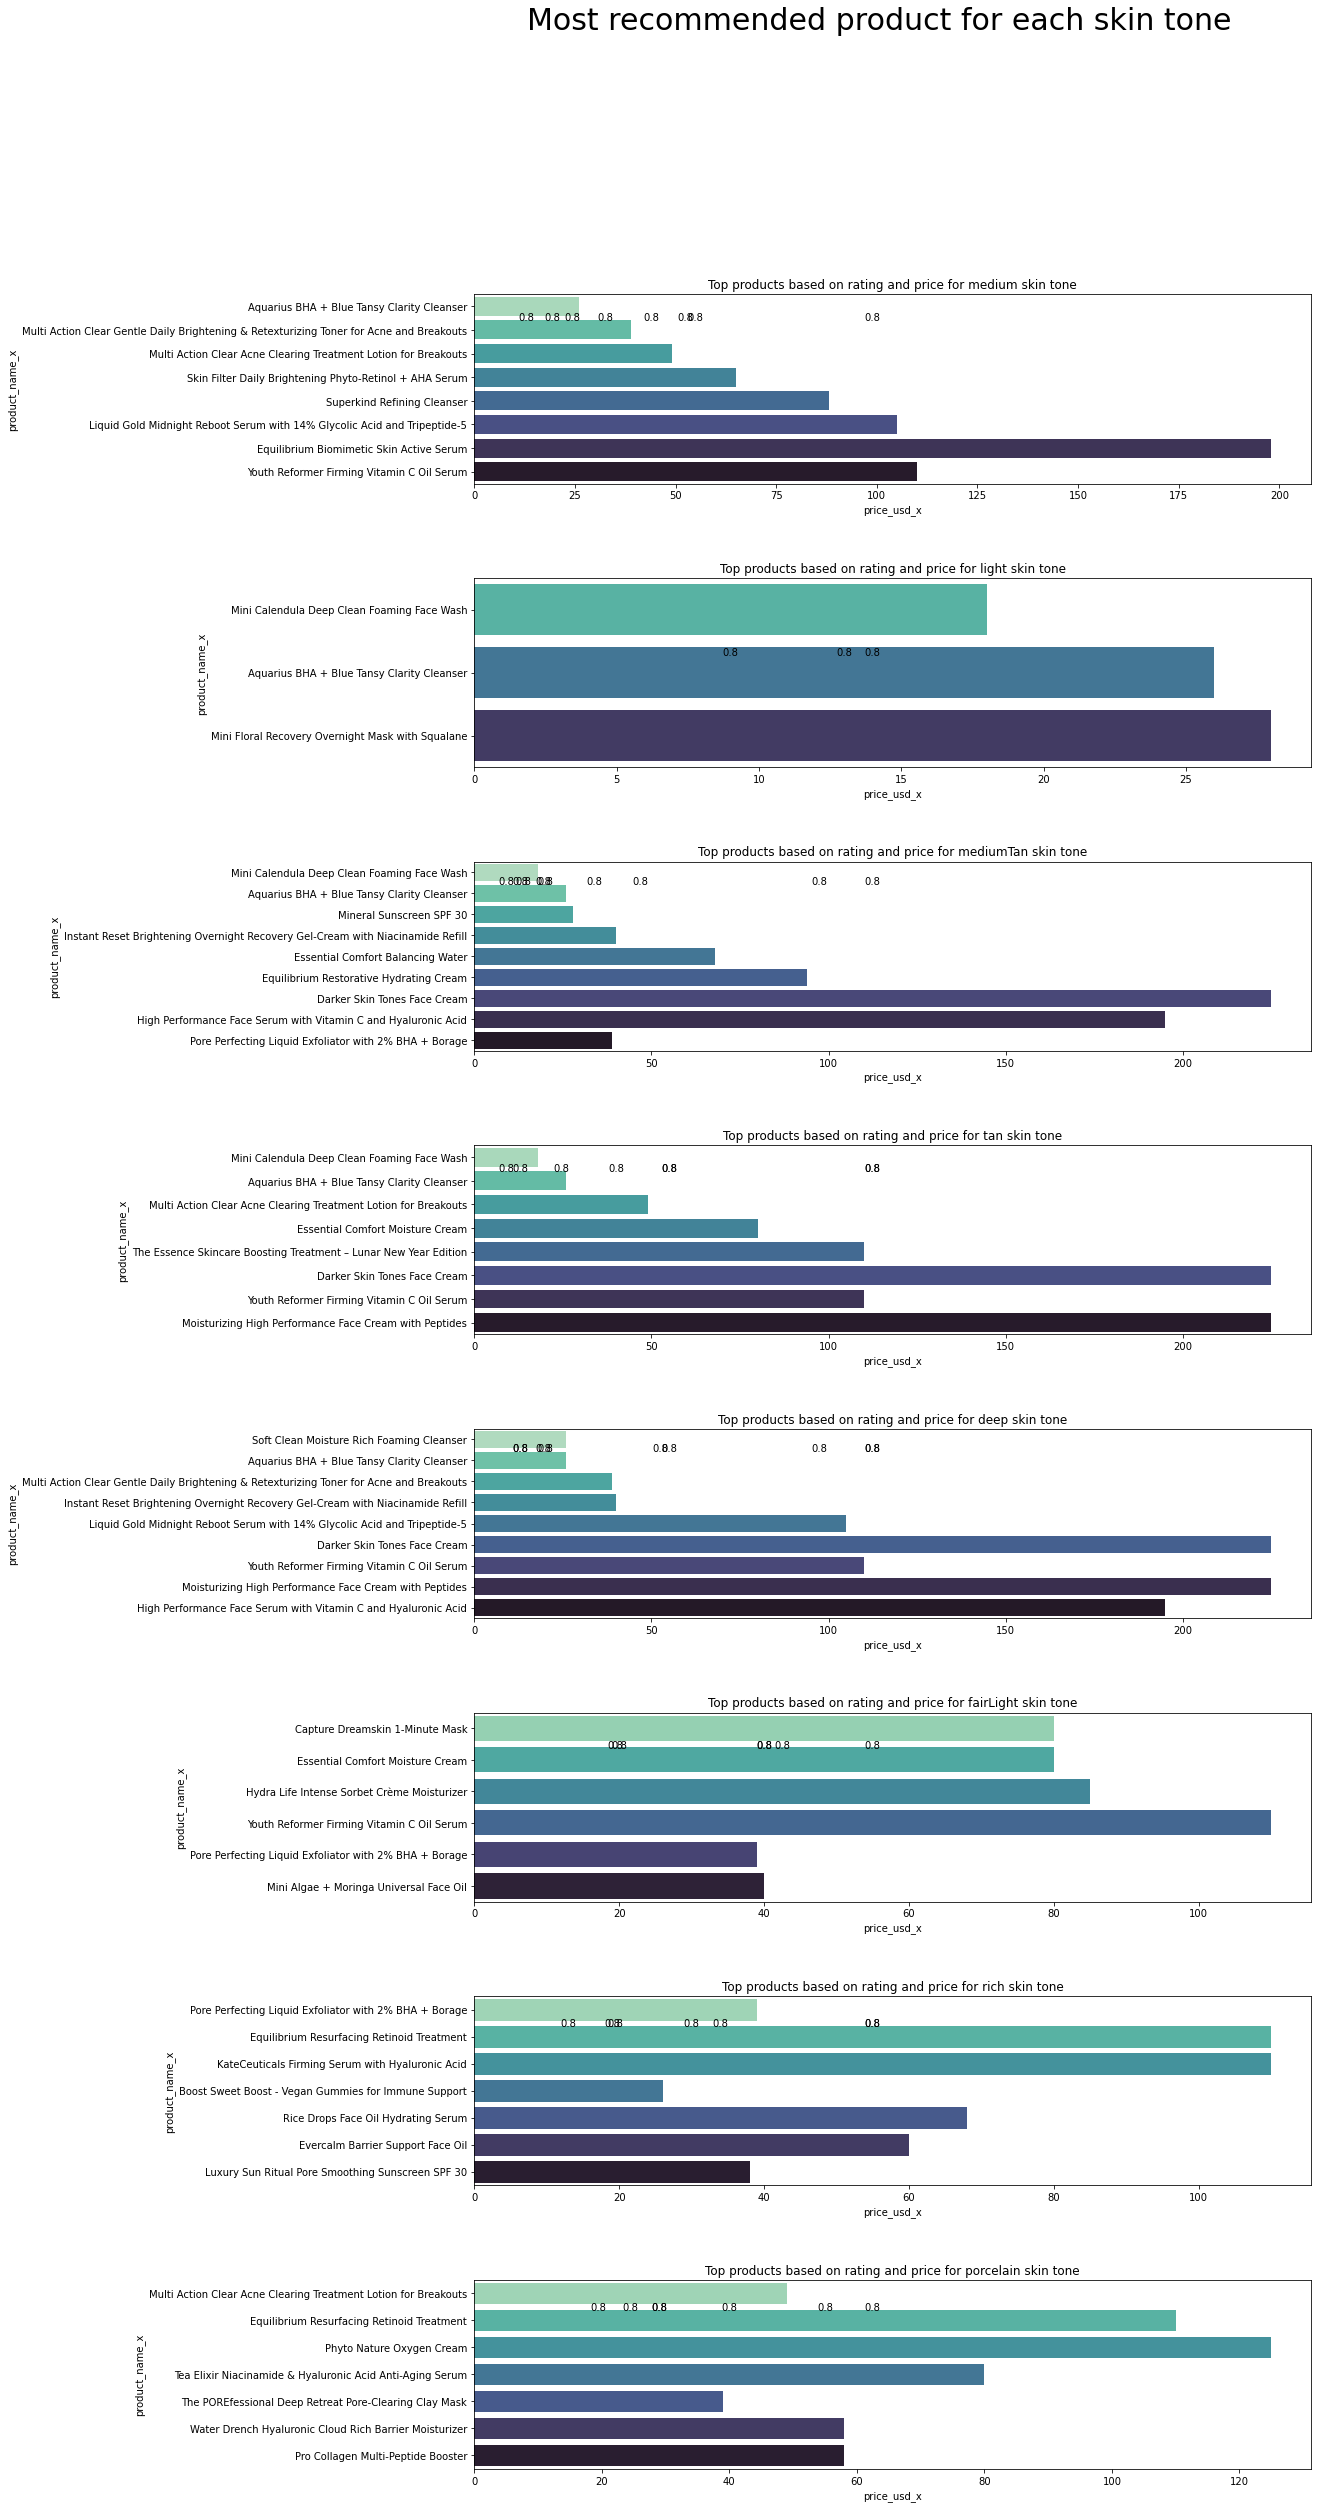

In [35]:
skin_tone = ['medium', 'light','mediumTan', 'tan', 'deep', 'fairLight', 'rich', 'porcelain',]
plot_top_products_by_skin_tone(new_data, skin_tone)

## Most recommended product for each hair color

In [36]:
def plot_top_products_by_hair_color(df, hair_color):
    # Create subplots based on the number of hair colors provided
    fig, axes = plt.subplots(nrows=len(hair_color), ncols=1, figsize=(15, 5*len(hair_color)))
    fig.subplots_adjust(hspace=0.5)
    
    # Iterate over each hair color
    for i, hair_color in enumerate(hair_color):
        ax = axes[i]
        
        # Filter the dataframe to include only rows with the current hair color
        hair_color_data = df[df['hair_color'] == hair_color].sort_values(['rating_x', 'price_usd_x'], ascending=[False, True]).head(10)
        
        # Create a bar plot showing the product names on the y-axis and the price on the x-axis
        ax = sns.barplot(data=hair_color_data, x='price_usd_x', y='product_name_x', ax=ax)
        ax.set_title(f"Top products based on rating and price for {hair_color} hair color")
        
        # Add labels to the bars showing their heights
        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                            textcoords='offset points', ha='center', va='bottom')
    
    # Set the title for the entire plot
    fig.suptitle("Most recommended product for each hair color", fontsize=30)
    
    # Display the plot
    plt.show()

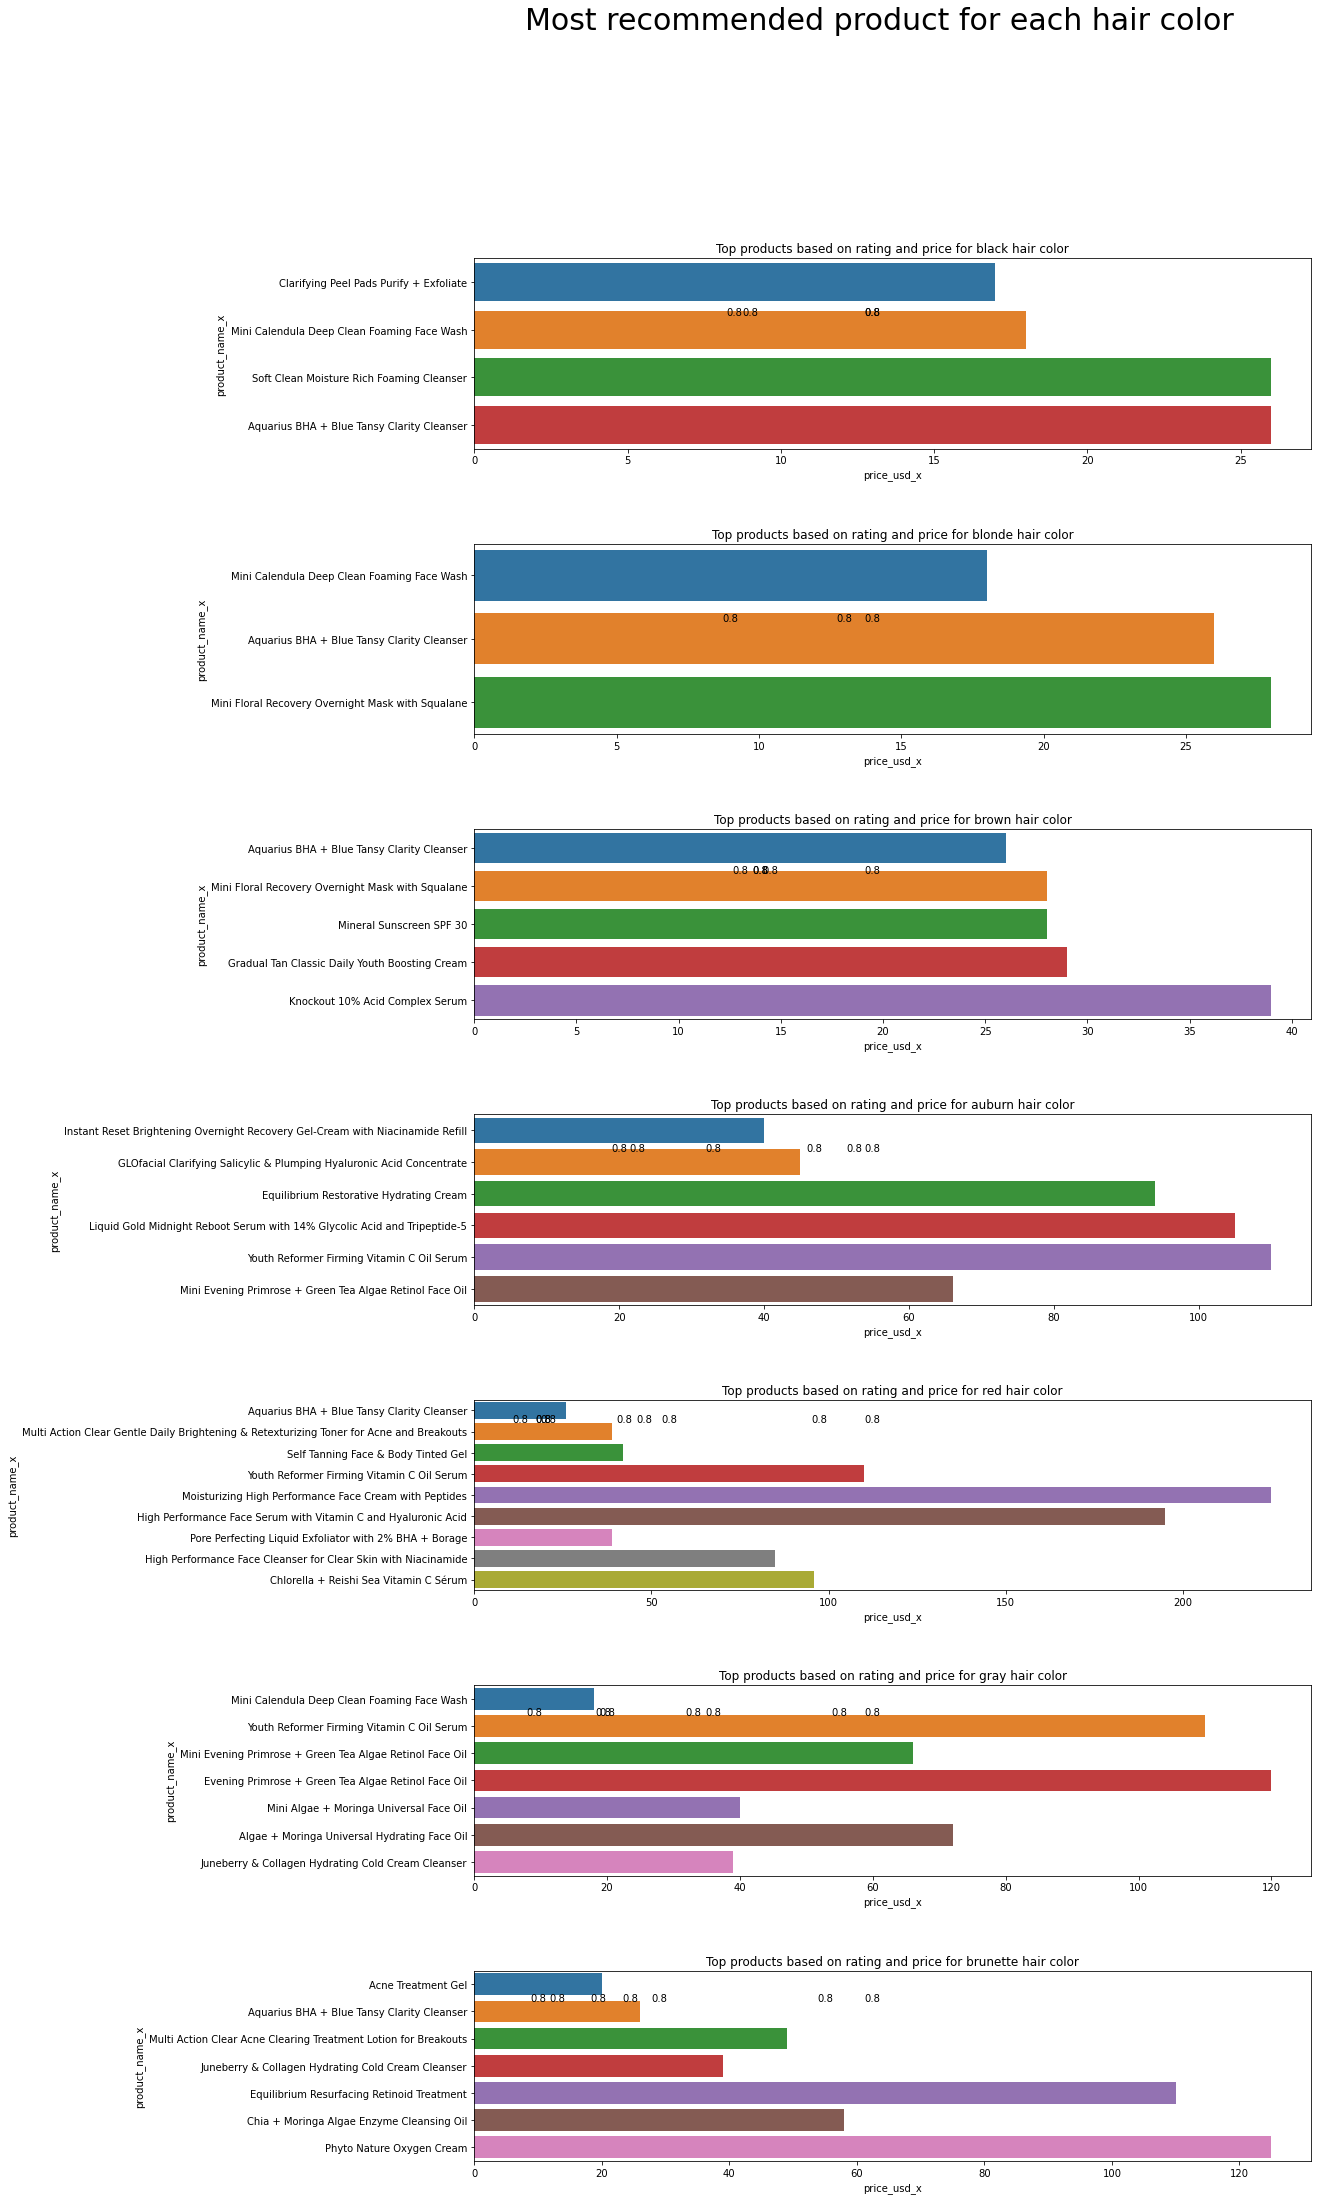

In [37]:
hair_color = ['black', 'blonde','brown',"auburn", "red", "gray", "brunette" ]
plot_top_products_by_hair_color(new_data, hair_color)

## Most recommended product for each eye color

In [38]:
def plot_top_products_by_eye_color(df, eye_color):
    # Create subplots based on the number of eye colors provided
    fig, axes = plt.subplots(nrows=len(eye_color), ncols=1, figsize=(15, 5*len(eye_color)))
    fig.subplots_adjust(hspace=0.5)
    
    # Iterate over each eye color
    for i, eye_color in enumerate(eye_color):
        ax = axes[i]
        
        # Filter the dataframe to include only rows with the current eye color
        eye_color_data = df[df['eye_color'] == eye_color].sort_values(['rating_x', 'price_usd_x'], ascending=[False, True]).head(10)
        
        # Create a bar plot showing the product names on the y-axis and the price on the x-axis
        ax = sns.barplot(data=eye_color_data, x='price_usd_x', y='product_name_x', ax=ax,)
        ax.set_title(f"Top products based on rating and price for {eye_color} eye color")
       
        # 
        # Add labels to the bars showing their heights
        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                            textcoords='offset points', ha='center', va='bottom')
    
    # Set the title for the entire plot
    fig.suptitle("Most recommended product for each eye color", fontsize=30)
    
    # Display the plot
    plt.show()

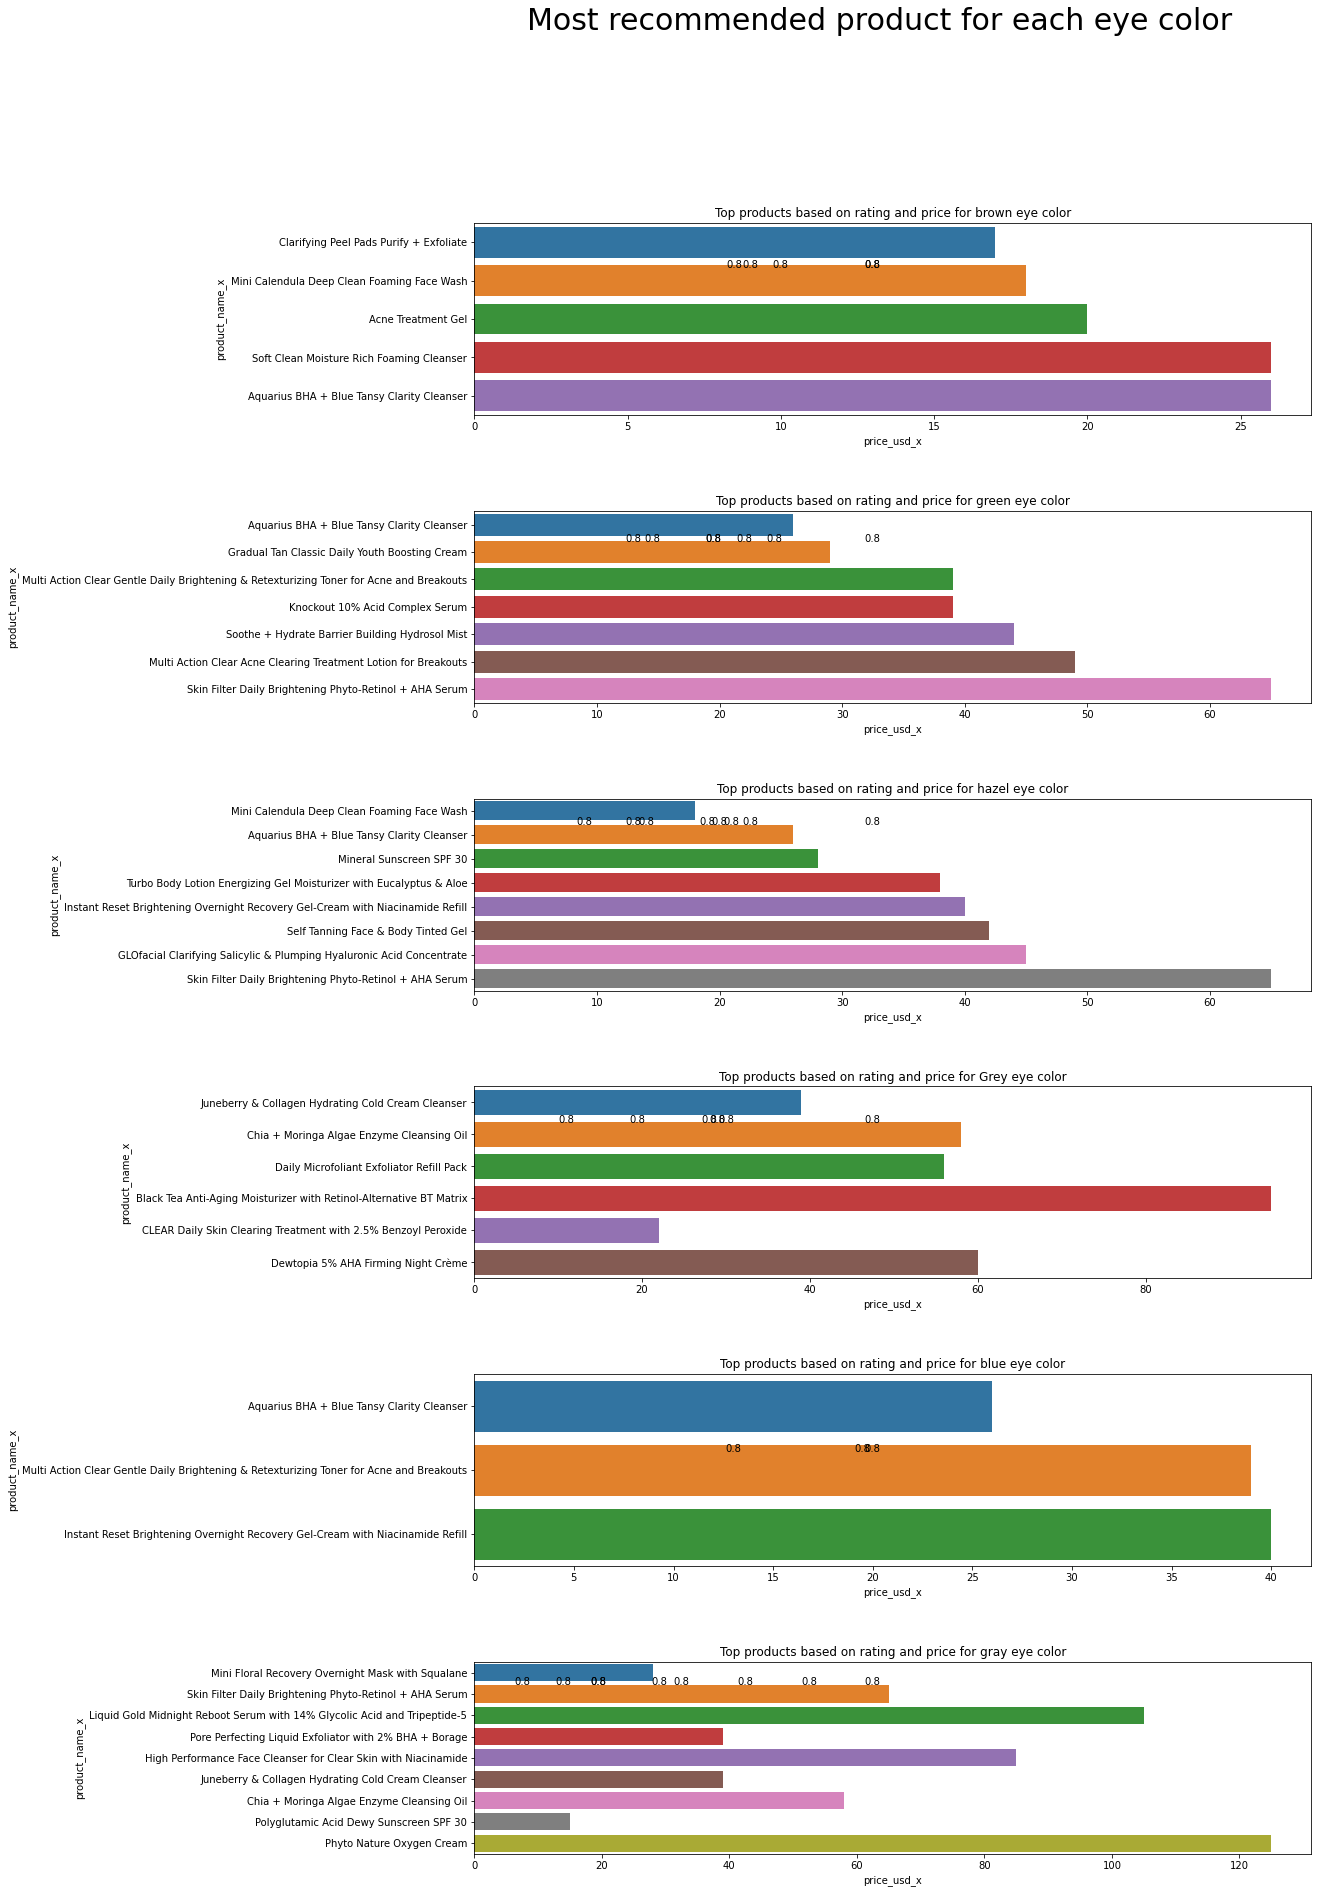

In [39]:
eye_color = ['brown',"green", "hazel", "Grey", "blue", "gray" ]
plot_top_products_by_eye_color(new_data, eye_color)

# Correlation and Multicollinearity

<AxesSubplot:>

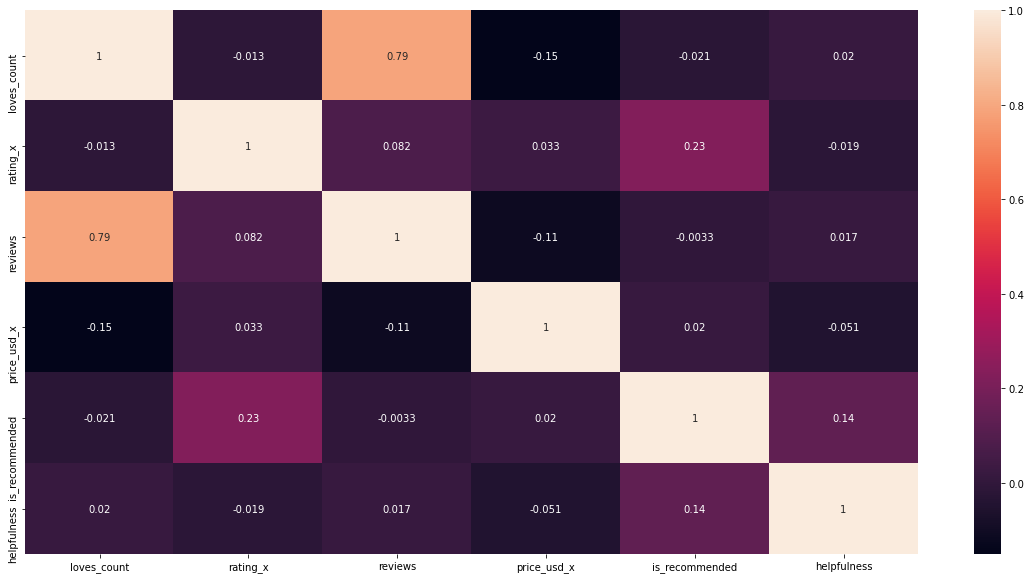

In [40]:
# set figsize
plt.figure(figsize = (20,10))
# Plot the correlation matrix as a heatmap
sns.heatmap(numerical_columns.corr(), annot =True)

 Using a pairplot to explore the relationships between multiple variables in a dataset and gain insights into the correlations and patterns among different variables.

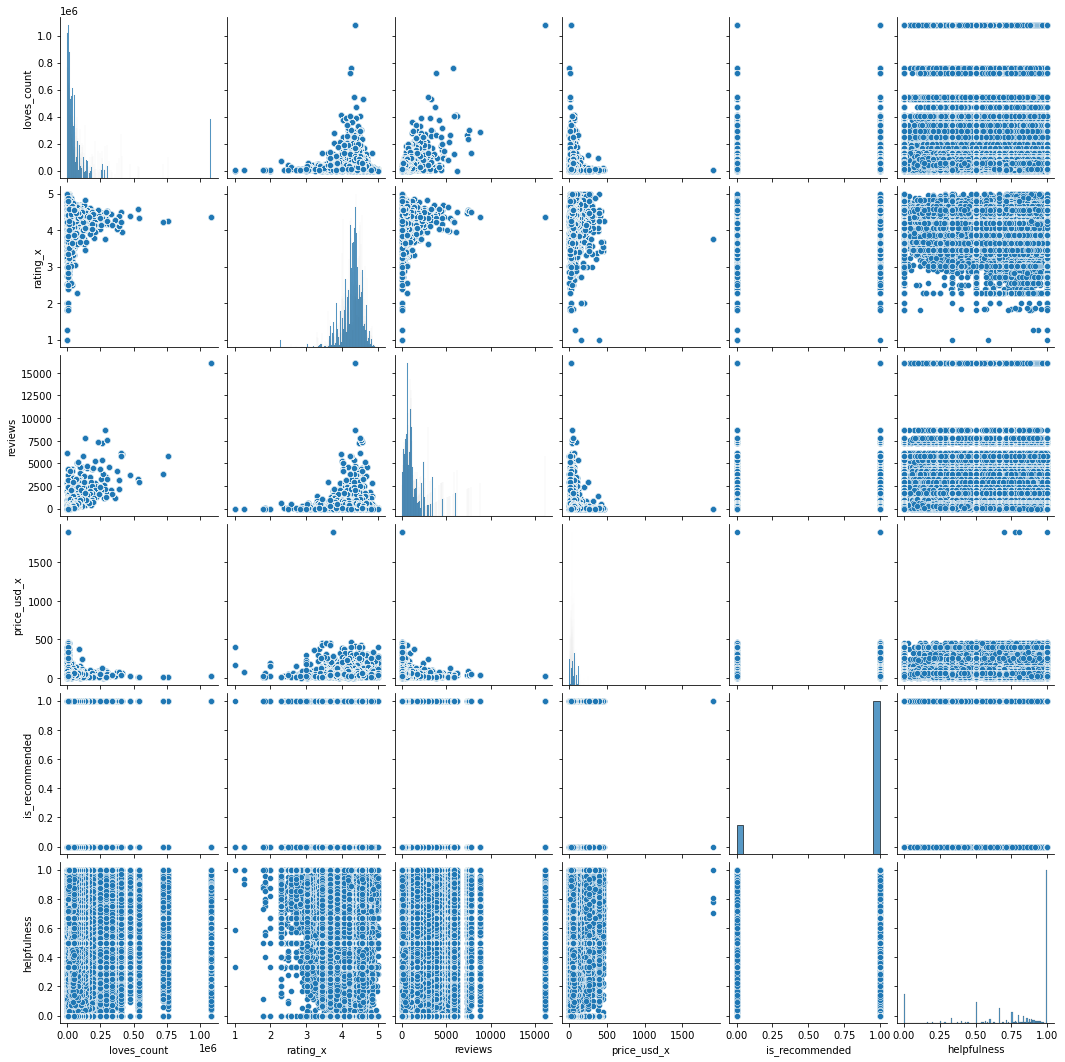

In [41]:
#pairplot of all the numerical columns
sns.pairplot(numerical_columns)

"The `reviews` and `loves_count` columns have a high correlation of 0.79 and a positive relationship. This correlation is likely because `loves_count` represents the number of people who have marked this product as a favorite, and `reviews` represents the number of user reviews for the product. Since people who loved a given product often leave a review, we should drop the `reviews` column to avoid multicollinearity."

In [42]:
new_data.drop(['reviews', 'review_text'] ,axis =1, inplace= True)

# Feature Engineering

To improve our user interface and offer customized recommendations, we're introducing a new price range column to our dataset. This addition is in response to our interface asking users for their budget. With this information, we can now filter and recommend products that match their specified budget, ensuring a more tailored and user-friendly experience.

In [43]:
# Engineer the price_range column
def engineer_price_range(price):
    if price < 32:
        return 'low'
    elif price < 68:
        return 'medium'
    else:
        return 'high'

new_data['price_range'] = new_data['price_usd_x'].apply(engineer_price_range)
new_data.head(3)

,author_id,product_id,product_name_x,brand_name_x,loves_count,rating_x,size,ingredients,price_usd_x,highlights,primary_category,secondary_category,tertiary_category,is_recommended,helpfulness,skin_tone,eye_color,skin_type,hair_color,price_range
0,5880814443,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,1.0,1.000000,medium,brown,oily,black,high
3,8222942765,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,1.0,0.800000,light,brown,combination,blonde,high
4,2403670662,P439055,GENIUS Sleeping Collagen Moisturizer,Algenist,33910.0,4.5413,2 oz/ 60 mL,"['Collagen (Vegan)*, Water (Aqua, Eau), Ethylh...",98.0,"['Vegan', 'Good for: Loss of firmness', 'Colla...",Skincare,Moisturizers,Moisturizers,0.0,0.111111,fair,green,combination,blonde,high


# Modelling

## Memory based collaborative filtering

The memory-based approach of collaborative filtering uses similarities, such as cosine similarity or Pearson correlation, between users or items to make recommendations. It then recommends items that the neighbors have liked or interacted with, based on their similarity scores. The preferences of these neighbors are aggregated to generate recommendations.

## 1. Nearest Neigbour

* Create a sparse matrix from user ratings on products: First, create mappings from unique author IDs and product names to indices to construct the sparse matrix.
* Fit a Nearest Neighbors model to the sparse matrix: Utilize the Nearest Neighbors algorithm to find similar products based on cosine similarity.
* Finally create a  function  that takes a product name as input and returns a list of recommended products that are similar to the input product based on user ratings.

In [44]:
# create a mapping from unique author IDs and product names to indices
author_ids = new_data['author_id'].unique()
author_id_to_index = {id: index for index, id in enumerate(author_ids)}
product_names = new_data['product_name_x'].unique()
product_name_to_index = {id: index for index, id in enumerate(product_names)}
# get the indices for the sparse matrix
row_indices = np.array([author_id_to_index[id] for id in new_data['author_id']])
col_indices = np.array([product_name_to_index[id] for id in new_data['product_name_x']])
ratings = np.array(new_data['rating_x'])
# create the sparse matrix
sparse_matrix = csr_matrix((ratings, (row_indices, col_indices)), shape=(len(author_ids), len(product_names)))
sparse_matrix

<359303x1513 sparse matrix of type '<class 'numpy.float64'>'
	with 629696 stored elements in Compressed Sparse Row format>

In [45]:

# instantiating Nearest Neighbors
nearest_neighbor_model = NearestNeighbors(metric='cosine', algorithm='brute')

#fitting the model to the sparse matrix
model = nearest_neighbor_model.fit(sparse_matrix)

In [46]:
""" generation of product recommendations based on similarities in user ratings """
def recommend_product(product_name):
    # Finding the index of the product in the pivot table
    product_index = product_name_to_index[product_name]

    # Finding the nearest neighbors of the given product
    distances, indices = model.kneighbors(sparse_matrix.getrow(product_index), n_neighbors=5)

    # Creating a list of recommended products
    recommended_products = []
    for index in indices.flatten():
        recommended_products.append(product_names[index])

    return recommended_products
recommend_product('1% Vitamin A Retinol Serum')


['Advanced Génifique Radiance Boosting Face Serum',
 'Tonique Confort Re-Hydrating Comforting Toner with Acacia Honey',
 'Mini The Cleansing Foam',
 'The Eye Balm Intense',
 'Hydra Zen Gel-Cream Oil-Free Moisturizer with Salicylic Acid']

 When the  `recommend_product` function  is called with a product name, it finds the index of the product, retrieves its nearest neighbors, and returns a list of recommended products.

##  Modelling Functions

First, we create a function to filter the data based on user input criteria, such as price range, tertiary category, skin type, and skin tone. The function selects a random product from the filtered data within the specified category. It generates a prediction using the provided model for the selected product and returns the product name and ingredients.

In [47]:
from surprise import accuracy


In [48]:
#function to recommend product  based on users features
def generate_recommendation(price_range, tertiary_category, skin_type, skin_tone, model):
    # Filter products based on user input criteria
    filtered_data = new_data[
        (new_data['price_range'] == price_range) &
        (new_data['tertiary_category'] == tertiary_category) &
        (new_data['skin_type'] == skin_type) &
        (new_data['skin_tone'] == skin_tone)
    ]
   # Select a random product from the filtered data
    if not filtered_data.empty:
        sorted_data = filtered_data.sort_values(by='rating_x', ascending=False)
        product_id = sorted_data['product_id'].iloc[0]
        # Generate prediction for the selected product
        prediction = model.predict('new_user', product_id)
        print(prediction)
        # Return product name and ingredients
        product_name = sorted_data['product_name_x'].iloc[0]
        ingredients = sorted_data['ingredients'].iloc[0]
        return product_name, ingredients
    return None, None

Then, we create  a function to evaluate our models using root mean squared error and mean squared error and   Precision, Recall, F1-Score

* Precision, Recall, F1-Score: These metrics are used in evaluating recommendation systems to measure the accuracy of the recommendations in terms of true positives, false positives, and false negatives.

* Mean Absolute Error (MAE): MAE measures the average difference between the predicted and actual values in a recommendation system. It provides an indication of the average magnitude of errors in the predictions.

* Root Mean Squared Error (RMSE): RMSE is another metric that measures the average prediction error in a recommendation system. It is similar to MAE but emphasizes larger errors more due to the squaring of differences. RMSE provides a measure of the standard deviation of the prediction errors.

* Precision, Recall, F1-Score: These metrics assess the accuracy of recommendations in a recommendation system. Precision measures the proportion of recommended items that are actually relevant, recall measures the proportion of relevant items that are recommended, and F1-Score is a combined metric that considers both precision and recall. These metrics help evaluate the effectiveness and quality of recommendations in terms of true positives, false positives, and false negatives.


In [49]:
def evaluate_model(model, test_data):
    from surprise import accuracy

    # Evaluate the recommendation model
    predictions = model.test(test_data)

    # Calculate RMSE and MAE
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    # Get actual and predicted ratings
    actual_ratings = [pred.r_ui for pred in predictions]
    predicted_ratings = [pred.est for pred in predictions]

    # Convert ratings to binary values for classification metrics
    actual_binary = [1 if rating >= 3 else 0 for rating in actual_ratings]
    predicted_binary = [1 if rating >= 3 else 0 for rating in predicted_ratings]

    # Calculate precision, recall, and accuracy
    precision = precision_score(actual_binary, predicted_binary)
    recall = recall_score(actual_binary, predicted_binary)
    accuracy = accuracy_score(actual_binary, predicted_binary)

    # Return a dictionary of metrics
    evaluation_metrics = {'RMSE': rmse, 'MAE': mae, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}
    return evaluation_metrics


## 2. KNNBasic

When fitting the model, we need to create a sample of the data because the dataset is huge. Using the entire dataset was causing the model to crash.

In [50]:
#creating a sample 
sample_data=new_data.sample(n=20000, random_state=42)

# Prepare the data for Surprise library
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(sample_data[['author_id', 'product_id', 'rating_x']], reader)
trainset1, testset1 = train_test_split(data, test_size=0.2, random_state=42)

model1 = KNNBasic(random_state=42)
model1.fit(trainset1)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [51]:
#knnbasic evaluation

evaluation_results = evaluate_model(model1, testset1)
print(evaluation_results)

RMSE: 0.2724
MAE:  0.2132
{'RMSE': 0.2723962364926829, 'MAE': 0.21318594462656246, 'Precision': 0.999, 'Recall': 1.0, 'Accuracy': 0.999}


In [52]:
# Example usage
price_range ='medium'
tertiary_category = 'Toners'
skin_type = 'oily'
skin_tone = 'light'

product_name, ingredients = generate_recommendation(price_range, tertiary_category, skin_type, skin_tone, model1)

if product_name is not None:
    print("Recommended Product:", product_name)
    print("Ingredients:", ingredients)
else:
    print("No recommendation found for the given input criteria.")

user: new_user   item: P480274    r_ui = None   est = 4.30   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
Recommended Product: GENIUS Liquid Skin Resurfacing 2% BHA Toner
Ingredients: ['Water (Aqua, Eau), Propanediol, Salicylic Acid, Niacinamide, Collagen Amino Acids, Parachlorella Beijerinckii Exopolysaccharides, Collagen, Azelaic Acid, Glycolic Acid, Decyl Glucoside, Eucalyptus Globulus Leaf Extract, Lauryl Glucoside, Rosmarinus Officinalis (Rosemary) Extract, Mentha Piperita (Peppermint) Extract, Citrus Limon (Lemon) Fruit Extract, Dextrin, Amylopectin, Polydextrose, Leuconostoc/Radish Root Ferment Filtrate, Tocopherol, Ethylhexylglycerin, Sodium Hydroxide, Phytic Acid, Butylene Glycol, Citric Acid, Sodium Benzoate, Potassium Sorbate, Phenoxyethanol.']


### Model Evaluation

*  An RMSE of 0.2724 means that, on average, the predicted ratings deviate from the actual ratings by approximately 0.2724 units.
*  The MAE value of 0.2132 represents the average absolute difference between predicted and actual ratings. 
* The Precision value of 0.999 indicates that the majority of recommendations made by the system are relevant. 
* A Recall value of 1.0 suggests that the system successfully identified all relevant recommendations.  an Accuracy score of 0.999 indicates a high level of correctness in the system's recommendations.

 Though  these metrics demonstrate that the recommender system performs well in terms of accuracy, relevance, and overall correctness, the model can only work on a sample and not the whole dataset so we cannot know it perfomance on the remaining 90% of the data, let's try other collaborative recommender models.






## User Based Collaborative Filtering

In this recommendation model, we first filter the data based on user features such as skin type, skin tone, and price range. After the data is filtered, we apply a user-based collaborative filtering approach, utilizing techniques like Singular Value Decomposition (SVD) and SVD++ (SVDpp). From these two approaches, we identify the best performer based on lower RMSE and MAE values, as well as good recall and precision values. We further tune the selected method. This collaborative filtering method takes into account the similarities between users and their preferences to generate personalized recommendations.

## 1.  SVD

In [53]:

# Prepare the data for Surprise library
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(new_data[['author_id', 'product_id', 'rating_x']], reader)
trainset2, testset2 = train_test_split(data, test_size=0.25, random_state=42)


In [54]:
# Build and train the recommendation model
model2 = SVD(random_state=42)
model2.fit(trainset2)

# making predictions
predictions2 = model2.test(testset2)

#svd evaluation
evaluation_results = evaluate_model(model2, testset2)
print(evaluation_results)

RMSE: 0.0343
MAE:  0.0158
{'RMSE': 0.034347287142718674, 'MAE': 0.01583605214510635, 'Precision': 0.9999111359366273, 'Recall': 0.9999809563710461, 'Accuracy': 0.9998922017475999}


In [55]:
# Example usage
price_range ='medium'
tertiary_category = 'Moisturizers'
skin_type = 'oily'
skin_tone = 'light'

product_name, ingredients = generate_recommendation(price_range, tertiary_category, skin_type, skin_tone, model2)

if product_name is not None:
    print("Recommended Product:", product_name)
    print("Ingredients:", ingredients)
else:
    print("No recommendation found for the given input criteria.")

user: new_user   item: P504044    r_ui = None   est = 4.71   {'was_impossible': False}
Recommended Product: Pro-Retinol Megamoisture Face Cream
Ingredients: ['Aqua (Water), Caprylic/Capric Triglyceride, Triethylhexanoin, Glycerin, Solanum Tuberosum (Potato) Pulp Extract, Squalane, Dicapryl Succinate, C12-16 Alcohols, Octyldodecyl PCA, C14-22 Alcohols, Behenyl Behenate, Carthamus Tinctorius (Safflower) Oleosomes, Helianthus Annuus (Sunflower) Seed Oil Unsaponifiables, Dunaliella Salina (Pink Algae) Extract, Argania Spinosa (Argan) Kernel Oil, Algin, Beta-Carotene, Quercetin, Sodium Hyaluronate, Tocopherol, Tocopheryl Acetate, Aloe Barbadensis Leaf Juice, Butyrospermum Parkii (Shea) Butter, Bisabolol, Citrullus Lanatus (Watermelon) Seed Oil, Cucumis Sativus (Cucumber) Fruit Water, Alpha-Glucan Oligosaccharide, Helianthus Annuus (Sunflower) Seed Oil, Olea Europaea (Olive) Fruit Oil, Mangifera Indica (Mango) Pulp Extract, Musa Sapientum (Banana) Pulp Extract, Spondias Mombin Pulp Extract, 

* An RMSE of 0.0343 indicates that the SVD recommender model has a low average deviation between predicted and actual ratings. The MAE value of 0.0158 further confirms the model's accuracy. Additionally, with precision and recall values close to 1 and an accuracy score of 0.9998, the SVD model provides highly accurate and relevant personalized recommendations.

### 2. SVDpp

In [56]:
# Build and train the recommendation model
model3 = SVDpp(random_state=42)
model3.fit(trainset2)# Build and train the recommendation model

# Evaluate the recommendation model
predictions3 = model3.test(testset2)

#svdpp evaluation
evaluation_results = evaluate_model(model3, testset2)
print(evaluation_results)


RMSE: 0.0290
MAE:  0.0113
{'RMSE': 0.02902253184493406, 'MAE': 0.011257133424332275, 'Precision': 0.9997207714323791, 'Recall': 1.0, 'Accuracy': 0.9997209927584939}


In [57]:
# Example usage
price_range ='medium'
tertiary_category = 'Face Serums'
skin_type = 'oily'
skin_tone = 'light'

product_name, ingredients = generate_recommendation(price_range, tertiary_category, skin_type, skin_tone, model3)

if product_name is not None:
    print("Recommended Product:", product_name)
    print("Ingredients:", ingredients)
else:
    print("No recommendation found for the given input criteria.")

user: new_user   item: P481348    r_ui = None   est = 4.79   {'was_impossible': False}
Recommended Product: Clinical 0.3% Retinol + 2% Bakuchiol Treatment
Ingredients: ['Water (Aqua), Dimethicone (Hydration/Skin-Softening), Pentaerythrityl Tetraisostearate (Texture Enhancer/Stabilizer), Isononyl Isononanoate (Emollient), Butylene Glycol (Slip Agent/Hydration), Bakuchiol (Skin-Restoring/Antioxidant), Arachidyl Alcohol (Texture Enhancer/Stabilizer), Glyceryl Polymethacrylate (Film-Forming Agent), Dimethicone Crosspolymer (Texture Enhancer), Behenyl Alcohol (Texture Enhancer), Glycerin (Skin-Replenishing), PEG-75 Shea Butter Glycerides (Emollient), Glyceryl Stearate (Texture Enhancer), C12-15 Alkyl Benzoate (Emollient), Polysorbate 20 (Emulsifier), Tetrahexyldecyl Ascorbate (Vitamin C/Antioxidant), Retinol (Vitamin A/Skin-Restoring), Ceramide NG (Skin-Replenishing), Palmitoyl Tetrapeptide-7 (Skin-Restoring), Palmitoyl Hexapeptide-12 (Skin-Restoring), Sodium Hyaluronate (Skin-Replenishing)

## SVDpp Evaluation

* With an RMSE  of 0.0290 and an MAE  of 0.0113, the model achieves a remarkably low average deviation between predicted and actual ratings, indicating its high accuracy. the Precision value of 0.9997 suggests that the majority of recommendations made by the system are relevant. The Recall value of 1.0 indicates that the model successfully identified all relevant recommendations. The Accuracy score of 0.9997 further demonstrates the overall correctness of the recommendations provided by the SVD++ model.

## Tuning SVDpp

In [58]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate
# Load the dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_data[["author_id", "product_id", "rating_x"]], reader)
# Define the parameter grid
param_grid = {'n_epochs': [10, 20, 30], 'n_factors': [50, 100, 150], 'lr_all': [0.002, 0.005, 0.01], 'reg_all': [0.02, 0.04, 0.06]}
# Perform grid search using cross-validation
best_score = float('inf')
best_params = {}
for n_epochs in param_grid['n_epochs']:
    for n_factors in param_grid['n_factors']:
        for lr_all in param_grid['lr_all']:
            for reg_all in param_grid['reg_all']:
                # Create and evaluate the SVD model with the current parameters
                model = SVDpp(n_epochs=n_epochs, n_factors=n_factors, lr_all=lr_all, reg_all=reg_all, random_state=42)
                results = cross_validate(model, data, measures=['RMSE'], cv=3, verbose=False)
                # Compute average RMSE score
                avg_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
                # Check if current parameters yield a better score
                if avg_rmse < best_score:
                    best_score = avg_rmse
                    best_params = {'n_epochs': n_epochs, 'n_factors': n_factors, 'lr_all': lr_all, 'reg_all': reg_all}
# Print the best RMSE score and the corresponding parameters
print("Best RMSE score:", best_score)
print("Best parameters:", best_params)

In [60]:
# Build and train the recommendation model
model3 = SVDpp(random_state=42, n_epochs = 50, n_factors = 50, lr_all = 0.01, reg_all = 0.02)
model3.fit(trainset2)# Build and train the recommendation model

# Evaluate the recommendation model
predictions3 = model3.test(testset2)

#svdpp evaluation
evaluation_results = evaluate_model(model3, testset2)
print(evaluation_results)


RMSE: 0.0283
MAE:  0.0099
{'RMSE': 0.028341024492150386, 'MAE': 0.009860071224788332, 'Precision': 0.9997715286636331, 'Recall': 1.0, 'Accuracy': 0.9997717213478586}


This tuned SVDpp is our final model, demonstrating outstanding performance with the lowest RMSE of 0.0283 and an MAE of 0.0099. The model's ability to minimize the deviation between actual and predicted ratings signifies its exceptional accuracy. With a precision value of 0.9998 and recall value of 1.0, the model generates highly relevant recommendations. Furthermore, the accuracy score of 0.9998 solidifies its effectiveness in delivering accurate and personalized recommendations.

# Deployment

In [ ]:
# import pickle
# # Save the model using pickle
# with open('svdpp_model.pkl', 'wb') as f:
#     pickle.dump(model3, f)

# # Load the model from the pickle file
# with open('svdpp_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f

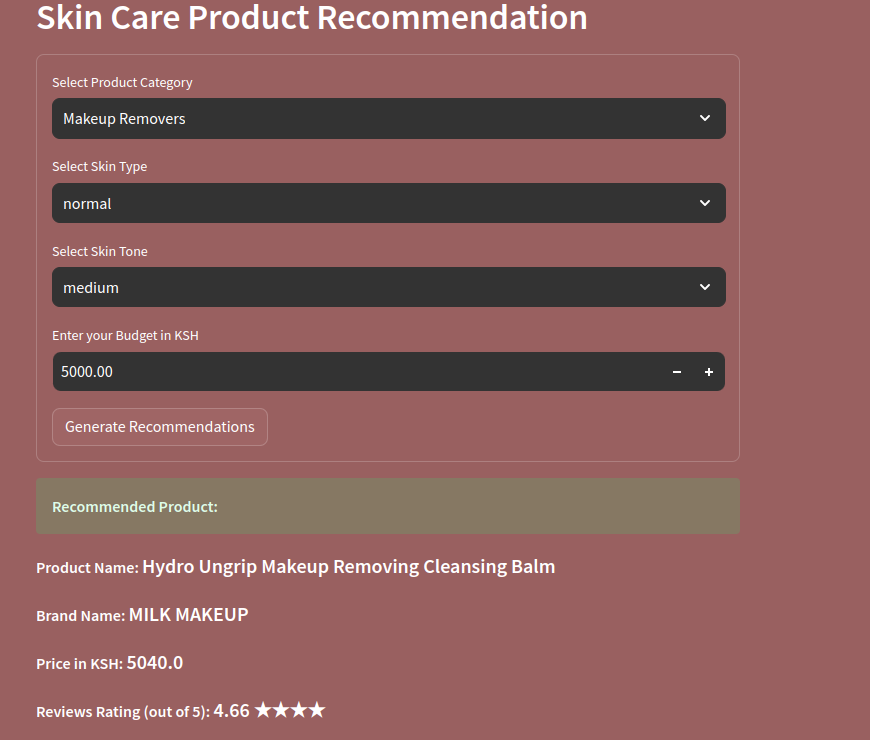

# Conclusion

In this skincare recommender system project, we developed several models to provide personalized skincare recommendations to users. We utilized memory-based collaborative filtering models, such as the Nearest Neighbors and KNNBasic models, as well as user-based collaborative filtering models, such as the SVD and SVDpp models.

Through evaluation, we found that all models performed well, with high precision, recall, and accuracy scores. The Tuned SVDpp model, after tuning, achieved the best results, demonstrating its ability to capture underlying relationships and provide accurate recommendations.

The deployment of the recommender system using Streamlit allows users to easily input their preferences and receive personalized skincare recommendations based on their budget, skin tone, skin type, and desired product type.

Overall, this project successfully demonstrates the effectiveness of collaborative filtering techniques in generating tailored skincare recommendations. By leveraging user preferences and product information, we enable users to discover skincare products that align with their needs and preferences.

The skincare recommender system has the potential to enhance the user experience, simplify product selection, and facilitate informed decision-making in the realm of skincare. We hope that this project serves as a useful tool for skincare enthusiasts and helps them find the most suitable products for their skincare routine.

# Recommendations

Based on our experience in developing the skincare recommender system, we would like to provide the following recommendations:

The business should provide more products such as face serums since they were rated as the most helpful.

They should collect more reviews from all races to improve the accuracy of the recommendation system.

They should Collaborate with skincare experts, dermatologists, or industry professionals who can provide valuable insights and expertise on the quality and safety of skincare products.

Alongside the product recommendations, the business can provide educational resources such as skincare guides, tutorials, and tips. This can help users make informed decisions about their skincare routines, understand the benefits of different ingredients, and address specific skin concerns

# Next Step

* Implementing NLP techniques to analyze user reviews and product descriptions can provide deeper insights into user preferences and product attributes. By extracting key features, sentiments, and opinions from textual data, the system can generate more accurate recommendations that align with users' specific needs and preferences.

* Investigate the use of deep learning models, such as convolutional neural networks (CNNs) or recurrent neural networks (RNNs), to capture complex patterns and relationships in skincare data. Deep learning models can potentially provide more nuanced and sophisticated recommendations by considering the intricate interactions between various skincare factors.

* Explore the integration of external data sources, such as social media platforms, beauty blogs, or skincare forums, to gather additional user-generated content and insights. By incorporating a broader range of user experiences and opinions, the system can offer more diverse and up-to-date recommendations.

* Establish partnerships with skincare brands and retailers to access real-time product data, promotional offers, and discounts. Collaborating with industry stakeholders can enhance the accuracy and relevance of the recommendations and provide users with exclusive benefits and personalized offers.



# 